<a href="https://colab.research.google.com/github/Derun-Chai/Assignment3/blob/https%2Fgithub.com%2FAlocinYerv%2FTulip.git/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Author:** Derun Chai

**Description:**

This notebook demonstrates the future price prediction for different stocks using recurrent neural networks in tensorflow. Recurrent neural networks with basic, LSTM, GRU cells or non-RNNs(ARIMA) are implemented.

**Outline:**

1. [Libraries and settings](#1-bullet)
2. [Analyze data](#2-bullet)
3. [Manipulate data](#3-bullet)
4. [Model and validate data](#4-bullet)
5. [Predictions](#5-bullet)

**Reference:**  

[LSTM_Stock_prediction-20170507 by BenF](https://www.kaggle.com/benjibb/lstm-stock-prediction-20170507/notebook)

# 1. Libraries and settings <a class="anchor" id="1-bullet"></a>

In [2]:
pip install --upgrade tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 85.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 97.7 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.14.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.14.0
    Uninstalling tensorflow-2.14.0:
      Successfully

In [3]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)
tf.compat.v1.enable_eager_execution()


# split data in 40%/20%/20% train/validation/test sets
valid_set_size_percentage = 20
test_set_size_percentage = 20

#display parent directory and working directory
print(os.path.dirname(os.getcwd())+':', os.listdir(os.path.dirname(os.getcwd())));
print(os.getcwd()+':', os.listdir(os.getcwd()));


2.15.0
/: ['tmp', 'run', 'lib32', 'opt', 'libx32', 'var', 'dev', 'bin', 'mnt', 'srv', 'home', 'lib', 'proc', 'boot', 'sys', 'etc', 'media', 'sbin', 'lib64', 'usr', 'root', 'content', '.dockerenv', 'tools', 'datalab', 'python-apt', 'NGC-DL-CONTAINER-LICENSE', 'cuda-keyring_1.0-1_all.deb']
/content: ['.config', 'prices-split-adjusted.csv', 'sample_data']


# 2. Analyze data <a class="anchor" id="2-bullet"></a>
- load stock prices from prices-split-adjusted.csv
- analyze data

In [4]:
# import all stock prices
df = pd.read_csv("prices-split-adjusted.csv", index_col = 0)
df.info()
df.head()

# number of different stocks
print('\nnumber of different stocks: ', len(list(set(df.symbol))))
print(list(set(df.symbol))[:10])

<class 'pandas.core.frame.DataFrame'>
Index: 221675 entries, 2016-01-05 to 2011-11-14
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  221675 non-null  object 
 1   open    221675 non-null  float64
 2   close   221675 non-null  float64
 3   low     221674 non-null  float64
 4   high    221674 non-null  float64
 5   volume  221674 non-null  float64
dtypes: float64(5), object(1)
memory usage: 11.8+ MB

number of different stocks:  471
['DLR', 'HBAN', 'MJN', 'AYI', 'ICE', 'TSN', 'PKI', 'IRM', 'YHOO', 'DAL']


In [5]:
df.tail()

,symbol,open,close,low,high,volume
date,,,,,,
2011-11-14,PSA,124.760002,123.019997,122.339996,125.220001,901400.0
2011-11-14,PVH,70.459999,70.290001,69.849998,71.269997,392700.0
2011-11-14,PWR,19.000000,18.770000,18.490000,19.059999,2259100.0
2011-11-14,PX,101.099998,101.389999,99.940002,101.500000,1032700.0
2011-11-14,PXD,92.930000,93.000000,NaN,NaN,NaN


In [6]:
df.describe()

,open,close,low,high,volume
count,221675.000000,221675.000000,221674.000000,221674.000000,2.216740e+05
mean,44.368583,44.386386,43.827288,44.892859,7.078490e+06
std,38.997651,39.011817,38.523293,39.461045,1.672430e+07
min,2.980000,3.020000,2.820000,3.200000,0.000000e+00
25%,23.510000,23.514981,23.180000,23.809999,1.488300e+06
50%,35.750000,35.761429,35.320000,36.150002,3.128400e+06
75%,53.630001,53.641578,53.020000,54.209999,6.629575e+06
max,556.469971,555.650024,551.219971,561.880005,8.596434e+08


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221675 entries, 2016-01-05 to 2011-11-14
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  221675 non-null  object 
 1   open    221675 non-null  float64
 2   close   221675 non-null  float64
 3   low     221674 non-null  float64
 4   high    221674 non-null  float64
 5   volume  221674 non-null  float64
dtypes: float64(5), object(1)
memory usage: 11.8+ MB


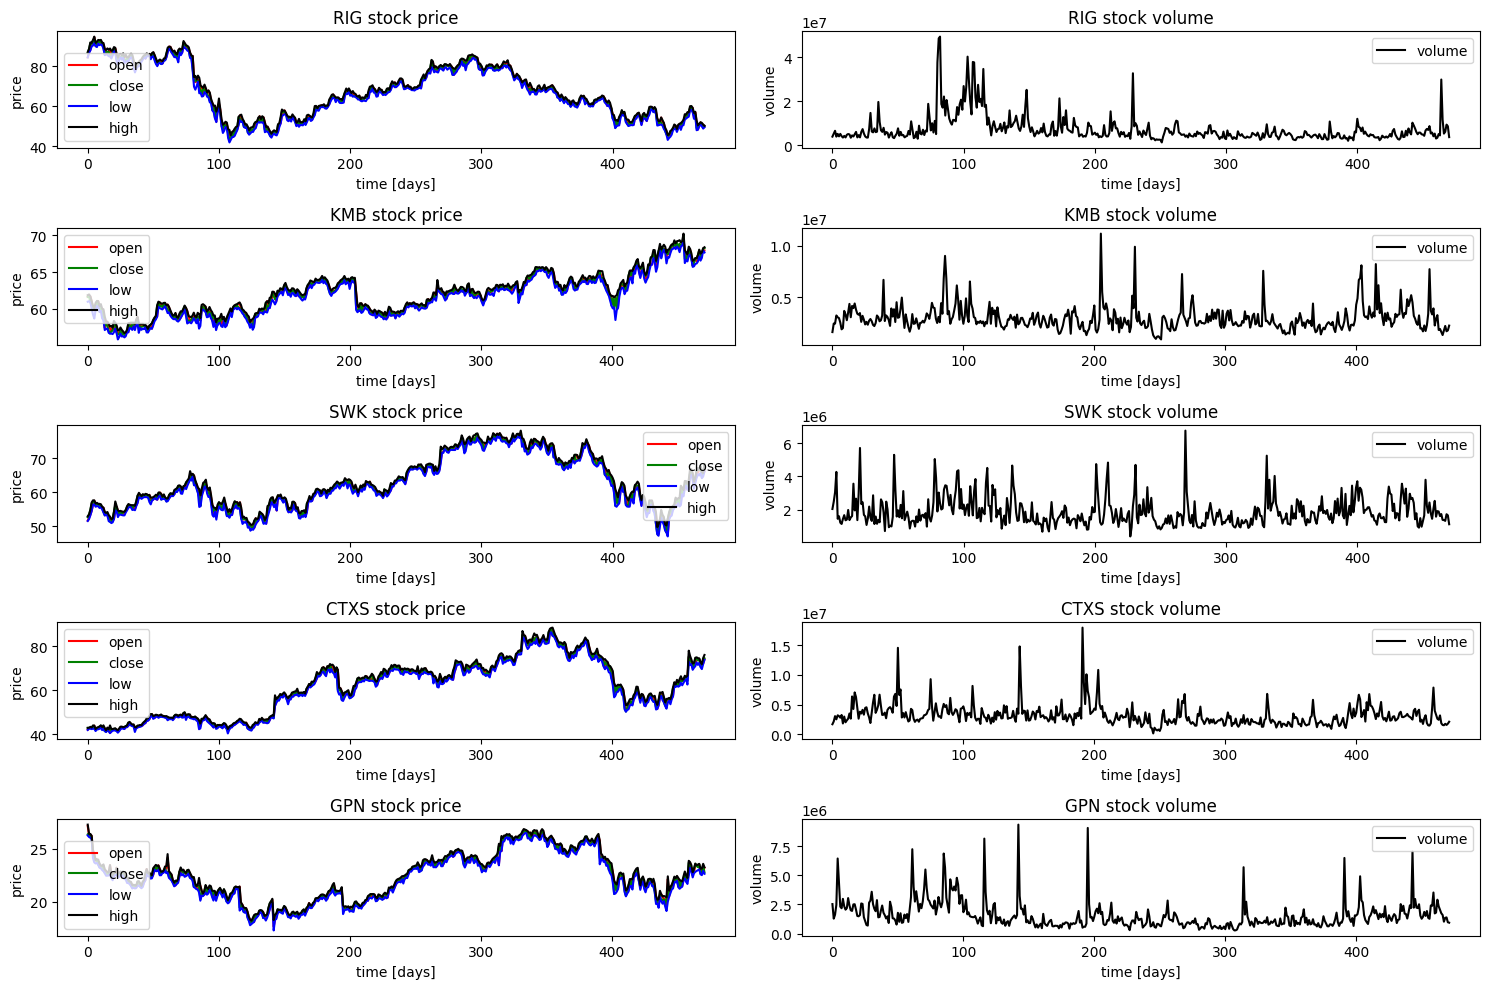

In [8]:
plt.figure(figsize=(15, 10))

# List of stocks to plot
stocks = ['RIG', 'KMB', 'SWK', 'CTXS', 'GPN']

# Plotting price data for each stock
for i, stock in enumerate(stocks, 1):
    plt.subplot(5, 2, 2*i-1)  # 5 rows, 2 columns, ith plot
    plt.plot(df[df.symbol == stock].open.values, color='red', label='open')
    plt.plot(df[df.symbol == stock].close.values, color='green', label='close')
    plt.plot(df[df.symbol == stock].low.values, color='blue', label='low')
    plt.plot(df[df.symbol == stock].high.values, color='black', label='high')
    plt.title(f'{stock} stock price')
    plt.xlabel('time [days]')
    plt.ylabel('price')
    plt.legend(loc='best')

# Plotting volume data for each stock
for i, stock in enumerate(stocks, 1):
    plt.subplot(5, 2, 2*i)  # 5 rows, 2 columns, ith plot
    plt.plot(df[df.symbol == stock].volume.values, color='black', label='volume')
    plt.title(f'{stock} stock volume')
    plt.xlabel('time [days]')
    plt.ylabel('volume')
    plt.legend(loc='best')

plt.tight_layout()
plt.show()

# 3. Manipulate data <a class="anchor" id="3-bullet"></a>
- choose a specific stock
- drop feature: volume
- normalize stock data
- create train, validation and test data sets

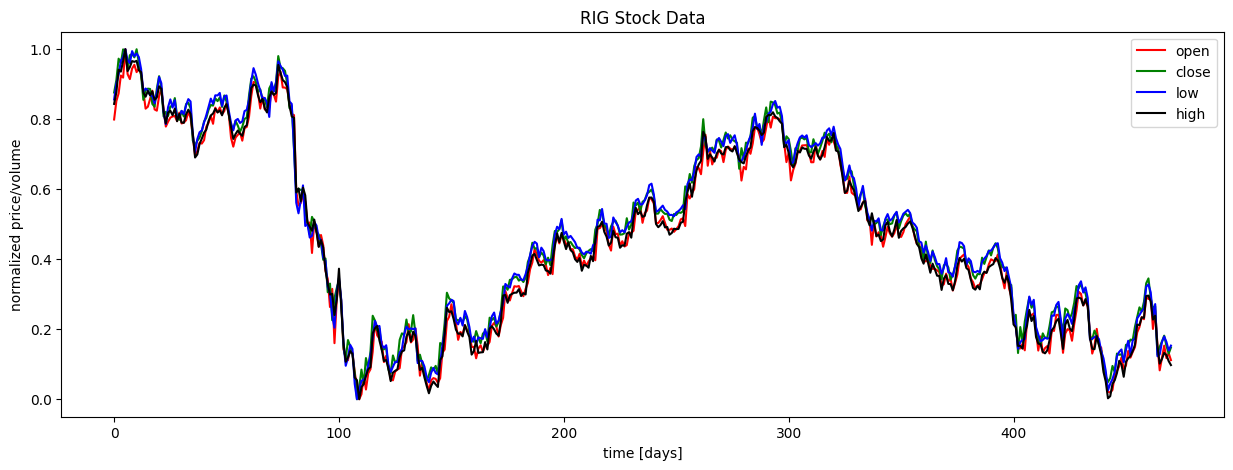

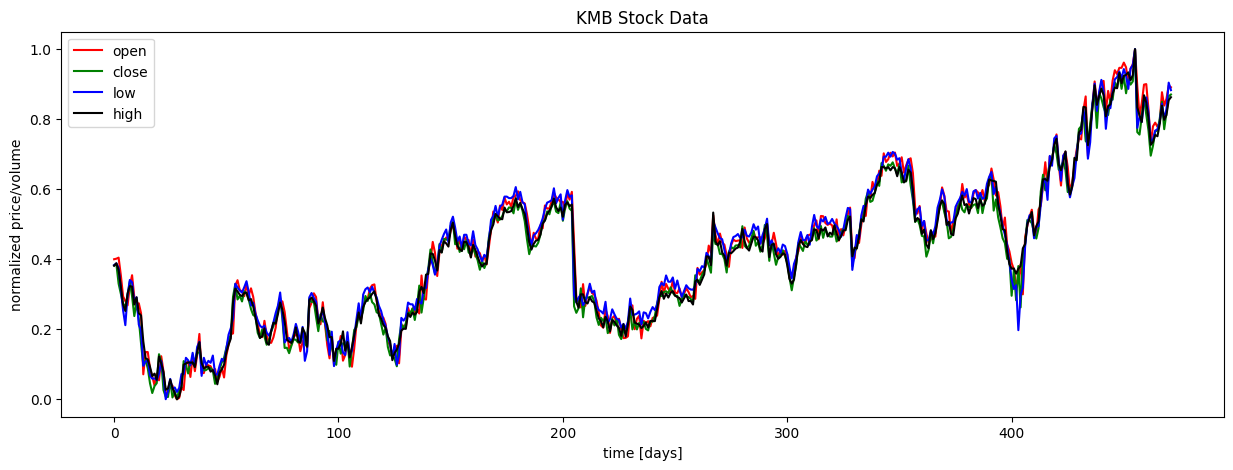

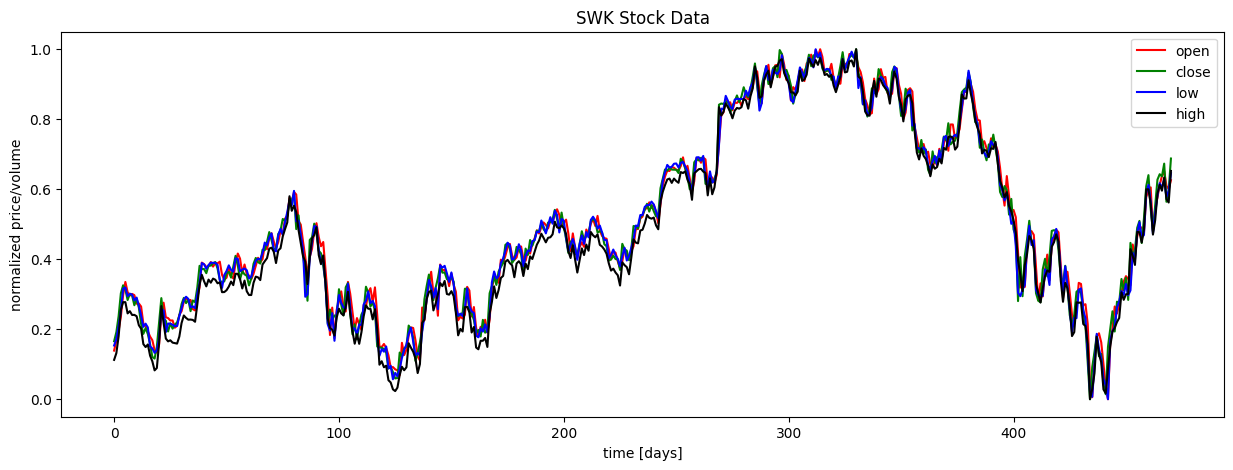

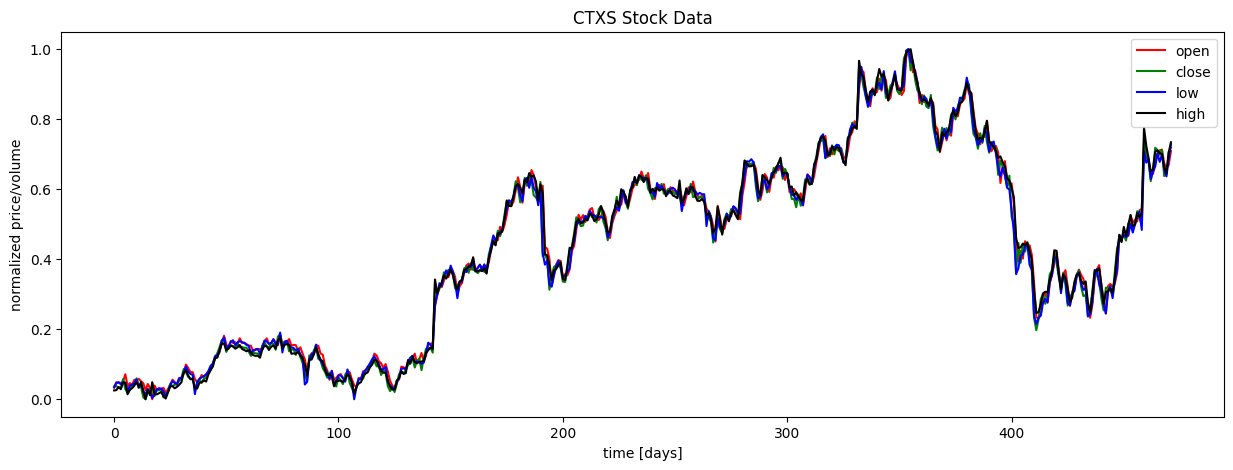

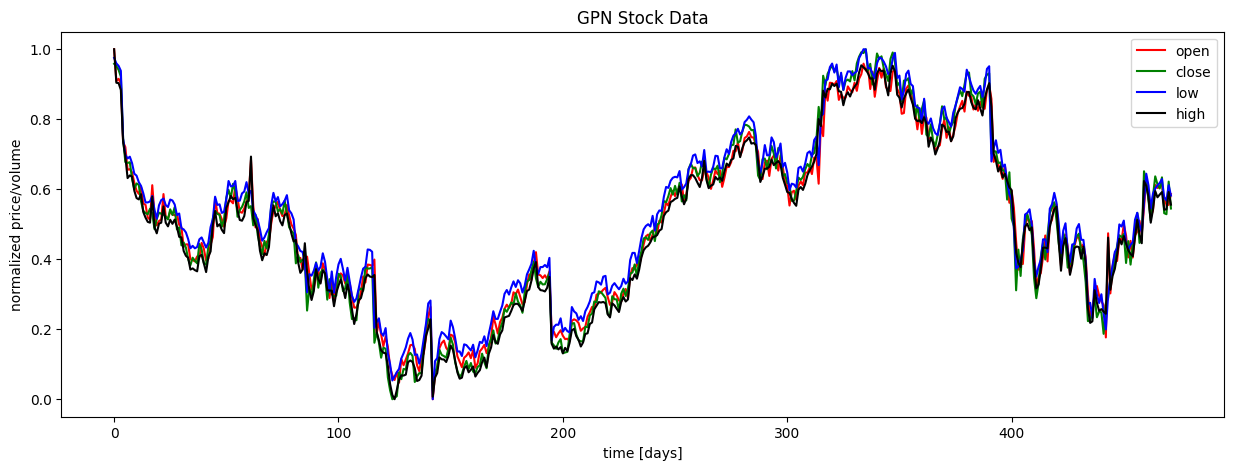

x_train.shape =  (1808, 19, 4)
y_train.shape =  (1808, 4)
x_valid.shape =  (225, 19, 4)
y_valid.shape =  (225, 4)
x_test.shape =  (225, 19, 4)
y_test.shape =  (225, 4)


In [9]:
import numpy as np
import sklearn.preprocessing

# Function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
    if 'volume' in df.columns:
        df['volume'] = min_max_scaler.fit_transform(df['volume'].values.reshape(-1,1))
    return df

# Function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len, train_size_percentage, valid_size_percentage, test_size_percentage):
    data_raw = stock.values # convert to numpy array
    data = []

    # Create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len):
        data.append(data_raw[index: index + seq_len])

    data = np.array(data)
    train_set_size = int(np.round(train_size_percentage/100*data.shape[0]))
    valid_set_size = int(np.round(valid_size_percentage/100*data.shape[0]))
    test_set_size = data.shape[0] - train_set_size - valid_set_size

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]

    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]

    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# List of stocks to include
stocks = ['RIG', 'KMB', 'SWK', 'CTXS', 'GPN']

# Initialize empty arrays for concatenating data
x_trains, y_trains, x_valids, y_valids, x_tests, y_tests = [], [], [], [], [], []
scalers = {}
seq_len = 20 # Choose sequence length

# Loop through each stock
for stock in stocks:
    df_stock = df[df['symbol'] == stock].copy()
    df_stock.drop(labels=['symbol'], axis=1, inplace=True)  # Corrected to avoid FutureWarning

    # Drop volume column if not needed
    df_stock = df_stock.drop(columns=['volume'])

    # Create a new scaler for each stock
    scaler = sklearn.preprocessing.MinMaxScaler()
    df_stock_norm = df_stock.copy()

    # Normalize stock data without 'volume'
    for col in df_stock_norm.columns:
        df_stock_norm[col] = scaler.fit_transform(df_stock_norm[col].values.reshape(-1,1))

    scalers[stock] = scaler

    # Create train, test, validation data
    x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len, 80, 10, 10)

    # Append the data
    x_trains.append(x_train)
    y_trains.append(y_train)
    x_valids.append(x_valid)
    y_valids.append(y_valid)
    x_tests.append(x_test)
    y_tests.append(y_test)
    # Plotting
    plt.figure(figsize=(15, 5))
    plt.plot(df_stock_norm.open.values, color='red', label='open')
    plt.plot(df_stock_norm.close.values, color='green', label='close')
    plt.plot(df_stock_norm.low.values, color='blue', label='low')
    plt.plot(df_stock_norm.high.values, color='black', label='high')

    plt.title(f'{stock} Stock Data')
    plt.xlabel('time [days]')
    plt.ylabel('normalized price/volume')
    plt.legend(loc='best')
    plt.show()

# Concatenate the data from all stocks
x_train = np.concatenate(x_trains, axis=0)
y_train = np.concatenate(y_trains, axis=0)
x_valid = np.concatenate(x_valids, axis=0)
y_valid = np.concatenate(y_valids, axis=0)
x_test = np.concatenate(x_tests, axis=0)
y_test = np.concatenate(y_tests, axis=0)

print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ', x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)


# 4. Model and validate data <a class="anchor" id="4-bullet"></a>
- RNNs with basic, LSTM, GRU cells


Processing stock: RIG
Epoch 1/70
2/2 [==============================] - 2s 342ms/step - loss: 0.6714 - val_loss: 8.6289
Epoch 2/70
2/2 [==============================] - 0s 68ms/step - loss: 9.5164 - val_loss: 7.8433
Epoch 3/70
2/2 [==============================] - 0s 73ms/step - loss: 7.6379 - val_loss: 1.2069
Epoch 4/70
2/2 [==============================] - 0s 74ms/step - loss: 1.3414 - val_loss: 0.2923
Epoch 5/70
2/2 [==============================] - 0s 66ms/step - loss: 0.7022 - val_loss: 0.1261
Epoch 6/70
2/2 [==============================] - 0s 73ms/step - loss: 0.5966 - val_loss: 0.2150
Epoch 7/70
2/2 [==============================] - 0s 71ms/step - loss: 0.5969 - val_loss: 0.1402
Epoch 8/70
2/2 [==============================] - 0s 77ms/step - loss: 0.5041 - val_loss: 0.0451
Epoch 9/70
2/2 [==============================] - 0s 80ms/step - loss: 0.4763 - val_loss: 0.0859
Epoch 10/70
2/2 [==============================] - 0s 125ms/step - loss: 0.5271 - val_loss: 0.3731
Epoch

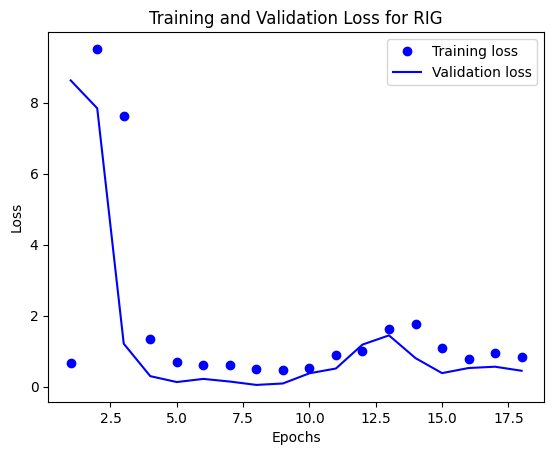

Processing stock: KMB
Epoch 1/70
2/2 [==============================] - 3s 581ms/step - loss: 0.8244 - val_loss: 2.9253
Epoch 2/70
2/2 [==============================] - 0s 117ms/step - loss: 4.5538 - val_loss: 15.0505
Epoch 3/70
2/2 [==============================] - 0s 117ms/step - loss: 12.0061 - val_loss: 2.2048
Epoch 4/70
2/2 [==============================] - 0s 71ms/step - loss: 2.2792 - val_loss: 3.0183
Epoch 5/70
2/2 [==============================] - 0s 73ms/step - loss: 3.6384 - val_loss: 2.1020
Epoch 6/70
2/2 [==============================] - 0s 78ms/step - loss: 2.3032 - val_loss: 2.8855
Epoch 7/70
2/2 [==============================] - 0s 89ms/step - loss: 3.1449 - val_loss: 1.3510
Epoch 8/70
2/2 [==============================] - 0s 77ms/step - loss: 1.6819 - val_loss: 2.5514
Epoch 9/70
2/2 [==============================] - 0s 73ms/step - loss: 2.1468 - val_loss: 0.4701
Epoch 10/70
2/2 [==============================] - 0s 74ms/step - loss: 0.9182 - val_loss: 0.1147
Ep

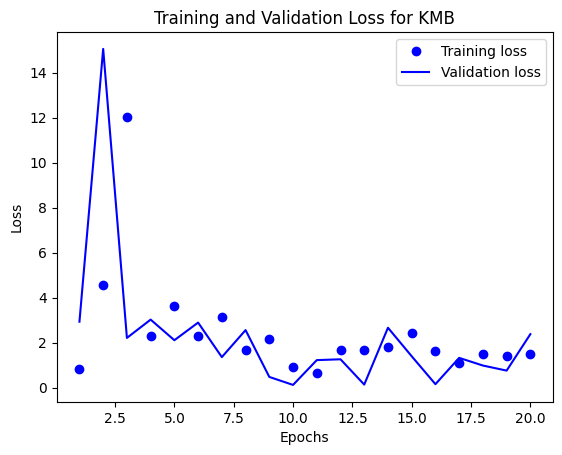

Processing stock: SWK
Epoch 1/70
2/2 [==============================] - 2s 349ms/step - loss: 1.1243 - val_loss: 12.4851
Epoch 2/70
2/2 [==============================] - 0s 73ms/step - loss: 12.0066 - val_loss: 6.1623
Epoch 3/70
2/2 [==============================] - 0s 77ms/step - loss: 5.9920 - val_loss: 1.6108
Epoch 4/70
2/2 [==============================] - 0s 74ms/step - loss: 1.7305 - val_loss: 0.2408
Epoch 5/70
2/2 [==============================] - 0s 86ms/step - loss: 0.6741 - val_loss: 0.0472
Epoch 6/70
2/2 [==============================] - 0s 73ms/step - loss: 0.4878 - val_loss: 0.0329
Epoch 7/70
2/2 [==============================] - 0s 75ms/step - loss: 0.4851 - val_loss: 0.0666
Epoch 8/70
2/2 [==============================] - 0s 73ms/step - loss: 0.5523 - val_loss: 0.1729
Epoch 9/70
2/2 [==============================] - 0s 69ms/step - loss: 0.6347 - val_loss: 0.3299
Epoch 10/70
2/2 [==============================] - 0s 73ms/step - loss: 0.7201 - val_loss: 0.2229
Epoc

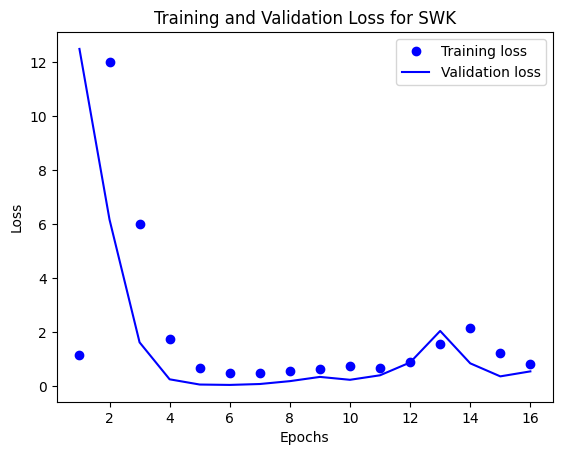

Processing stock: CTXS
Epoch 1/70
2/2 [==============================] - 2s 339ms/step - loss: 1.6294 - val_loss: 5.7359
Epoch 2/70
2/2 [==============================] - 0s 111ms/step - loss: 6.8830 - val_loss: 4.2828
Epoch 3/70
2/2 [==============================] - 0s 124ms/step - loss: 4.7962 - val_loss: 2.3221
Epoch 4/70
2/2 [==============================] - 0s 115ms/step - loss: 3.1558 - val_loss: 3.8083
Epoch 5/70
2/2 [==============================] - 0s 139ms/step - loss: 3.4706 - val_loss: 0.4257
Epoch 6/70
2/2 [==============================] - 0s 164ms/step - loss: 0.6985 - val_loss: 0.0677
Epoch 7/70
2/2 [==============================] - 0s 140ms/step - loss: 0.5237 - val_loss: 0.0470
Epoch 8/70
2/2 [==============================] - 0s 146ms/step - loss: 0.4829 - val_loss: 0.0678
Epoch 9/70
2/2 [==============================] - 0s 127ms/step - loss: 0.4609 - val_loss: 0.0882
Epoch 10/70
2/2 [==============================] - 0s 112ms/step - loss: 0.4736 - val_loss: 0.1

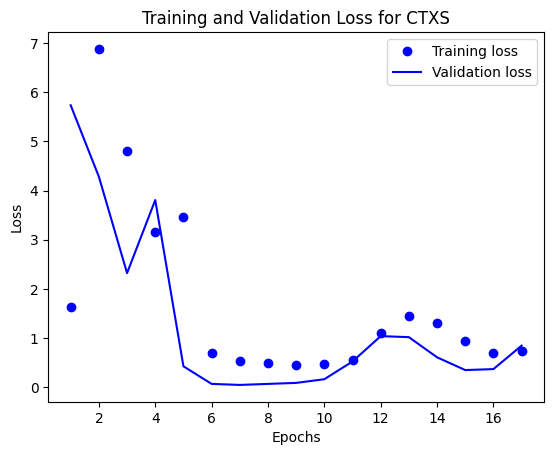

Processing stock: GPN
Epoch 1/70
2/2 [==============================] - 2s 345ms/step - loss: 0.9868 - val_loss: 4.1241
Epoch 2/70
2/2 [==============================] - 0s 72ms/step - loss: 4.5831 - val_loss: 12.6318
Epoch 3/70
2/2 [==============================] - 0s 81ms/step - loss: 11.3194 - val_loss: 1.5220
Epoch 4/70
2/2 [==============================] - 0s 80ms/step - loss: 1.7234 - val_loss: 0.2262
Epoch 5/70
2/2 [==============================] - 0s 78ms/step - loss: 0.7393 - val_loss: 0.1461
Epoch 6/70
2/2 [==============================] - 0s 78ms/step - loss: 0.5672 - val_loss: 0.0774
Epoch 7/70
2/2 [==============================] - 0s 82ms/step - loss: 0.4995 - val_loss: 0.0870
Epoch 8/70
2/2 [==============================] - 0s 69ms/step - loss: 0.5708 - val_loss: 0.1182
Epoch 9/70
2/2 [==============================] - 0s 75ms/step - loss: 0.5830 - val_loss: 0.1496
Epoch 10/70
2/2 [==============================] - 0s 76ms/step - loss: 0.6033 - val_loss: 0.2666
Epoc

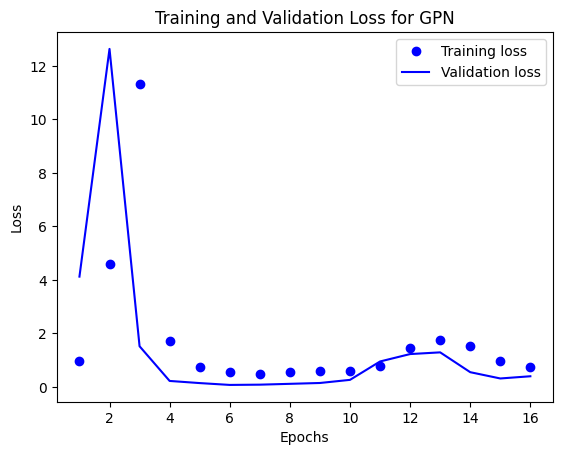

In [94]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# Model parameters
n_steps = 19  # Number of time steps
n_inputs = 4  # Number of features
n_neurons = 200  # Reduced number of neurons
n_outputs = 5   # Number of target features
n_layers = 2    # Number of RNN layers
learning_rate = 0.0085  # Reduced learning rate
batch_size = 130        # Adjusted batch size
n_epochs = 70
dropout_rate = 0.2     # Dropout rate for regularization


stocks = ['RIG', 'KMB', 'SWK', 'CTXS', 'GPN']
window_size = 5
def calculate_moving_average(data, window_size=5):
    ma = np.zeros((data.shape[0] - window_size + 1, data.shape[1]))
    for i in range(data.shape[1]):
        ma[:, i] = np.convolve(data[:, i], np.ones(window_size) / window_size, mode='valid')
    return ma
for stock in stocks:
    print(f"Processing stock: {stock}")

    # Prepare data for the current stock
    df_stock = df[df.symbol == stock].copy()
    df_stock.drop(['symbol'], axis=1, inplace=True)
    df_stock_norm = normalize_data(df_stock)

    # Create train, validation, test data
    x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, n_steps, 40, 20, 40)

    # Calculate moving averages and residuals
    y_train_ma = calculate_moving_average(y_train, window_size)
    y_valid_ma = calculate_moving_average(y_valid, window_size)
    y_test_ma = calculate_moving_average(y_test, window_size)

    y_train_adjusted = y_train[window_size-1:]
    y_valid_adjusted = y_valid[window_size-1:]
    y_test_adjusted = y_test[window_size-1:]

    y_train_residual = y_train_adjusted - y_train_ma
    y_valid_residual = y_valid_adjusted - y_valid_ma
    y_test_residual = y_test_adjusted - y_test_ma

    x_train_adjusted = x_train[-y_train_residual.shape[0]:, :, :]
    x_valid_adjusted = x_valid[-y_valid_residual.shape[0]:, :, :]
    x_test_adjusted = x_test[-y_test_residual.shape[0]:, :, :]

    # Build the RNN model with dropout for regularization
    model_RNNs = tf.keras.Sequential()
    for i in range(n_layers):
        if i == n_layers - 1:
            model_RNNs.add(tf.keras.layers.SimpleRNN(n_neurons, return_sequences=False))
        else:
            model_RNNs.add(tf.keras.layers.SimpleRNN(n_neurons, return_sequences=True))
        model_RNNs.add(tf.keras.layers.Dropout(dropout_rate))  # Adding dropout
    model_RNNs.add(tf.keras.layers.Dense(n_outputs))

    # Compile the model with a modified learning rate
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    model_RNNs.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model with early stopping
    history = model_RNNs.fit(x_train_adjusted, y_train_residual, epochs=n_epochs, batch_size=batch_size,
                             validation_data=(x_valid_adjusted, y_valid_residual), callbacks=[early_stopping])

    # Predictions
    y_train_pred_residual = model_RNNs.predict(x_train_adjusted)
    y_valid_pred_residual = model_RNNs.predict(x_valid_adjusted)
    y_test_pred_residual = model_RNNs.predict(x_test_adjusted)

    # Final predictions (basic model prediction + predicted residual)
    y_train_final_pred = y_train_ma + y_train_pred_residual[:y_train_ma.shape[0], :]
    y_valid_final_pred = y_valid_ma + y_valid_pred_residual[:y_valid_ma.shape[0], :]
    y_test_final_pred = y_test_ma + y_test_pred_residual[:y_test_ma.shape[0], :]

    # Extract and plot the history of loss and validation loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(f'Training and Validation Loss for {stock}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


# Build the ARIMA model


Analyzing Stock: RIG


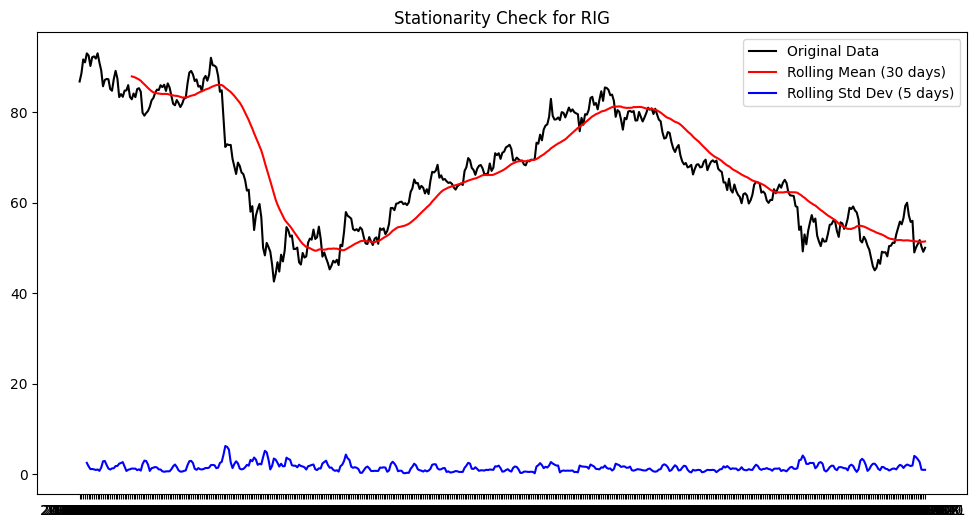

Dickey-Fuller Test: Stationarity Check for RIG

Test Statistic                  -1.542365
p-value                          0.512460
#Lags Used                       0.000000
Number of Observations Used    470.000000
dtype: float64
Critical value at 1%: -3.44434
Critical value at 5%: -2.86771
Critical value at 10%: -2.57006


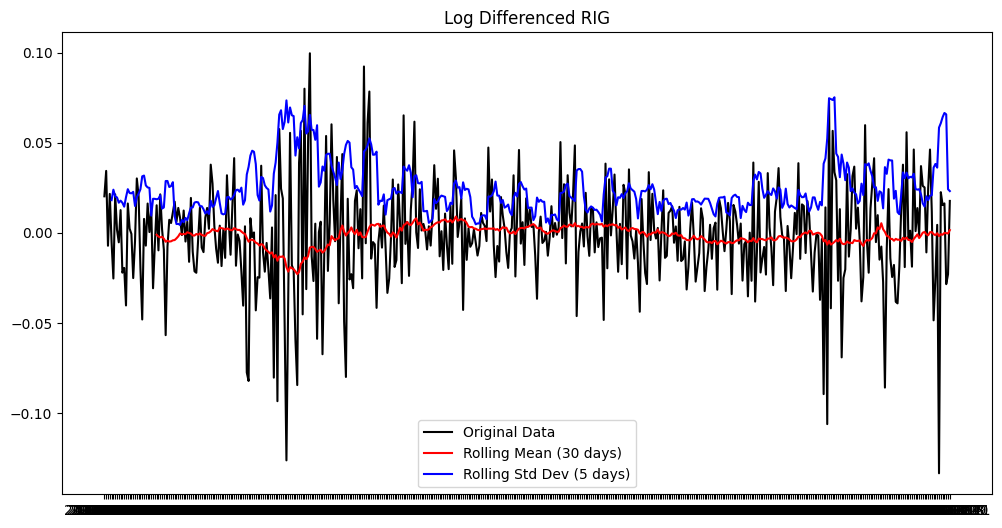

Dickey-Fuller Test: Log Differenced RIG

Test Statistic                -8.476410e+00
p-value                        1.431453e-13
#Lags Used                     6.000000e+00
Number of Observations Used    4.630000e+02
dtype: float64
Critical value at 1%: -3.44455
Critical value at 5%: -2.86780
Critical value at 10%: -2.57011
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  471
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -926.800
Date:                Wed, 22 Nov 2023   AIC                           1857.600
Time:                        09:01:33   BIC                           1865.905
Sample:                             0   HQIC                          1860.867
                                - 471                                         
Covariance Type:                  opg                                         
                 coef    std err          

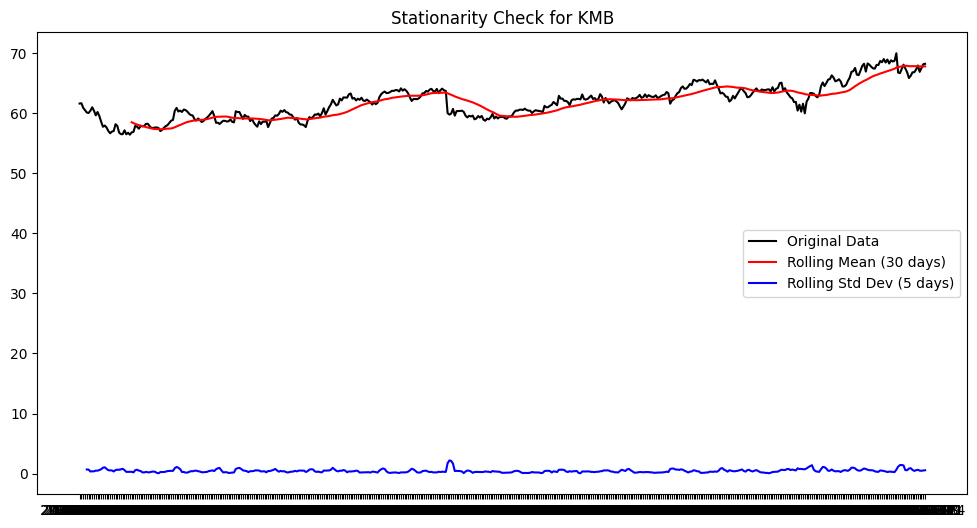

Dickey-Fuller Test: Stationarity Check for KMB

Test Statistic                  -1.219258
p-value                          0.665257
#Lags Used                       1.000000
Number of Observations Used    470.000000
dtype: float64
Critical value at 1%: -3.44434
Critical value at 5%: -2.86771
Critical value at 10%: -2.57006


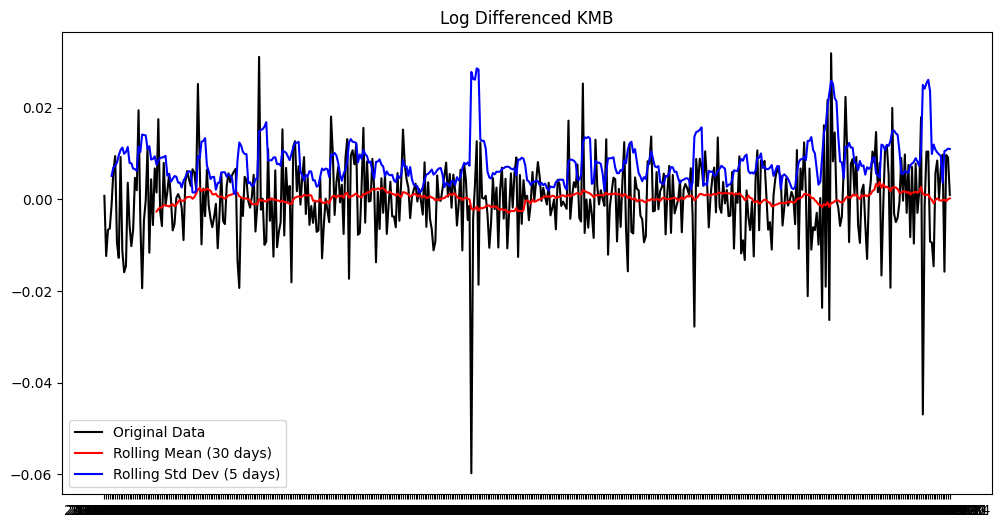

Dickey-Fuller Test: Log Differenced KMB

Test Statistic                -1.397536e+01
p-value                        4.271504e-26
#Lags Used                     2.000000e+00
Number of Observations Used    4.680000e+02
dtype: float64
Critical value at 1%: -3.44440
Critical value at 5%: -2.86774
Critical value at 10%: -2.57007
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  472
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -386.600
Date:                Wed, 22 Nov 2023   AIC                            777.200
Time:                        09:01:39   BIC                            785.510
Sample:                             0   HQIC                           780.469
                                - 472                                         
Covariance Type:                  opg                                         
                 coef    std err          

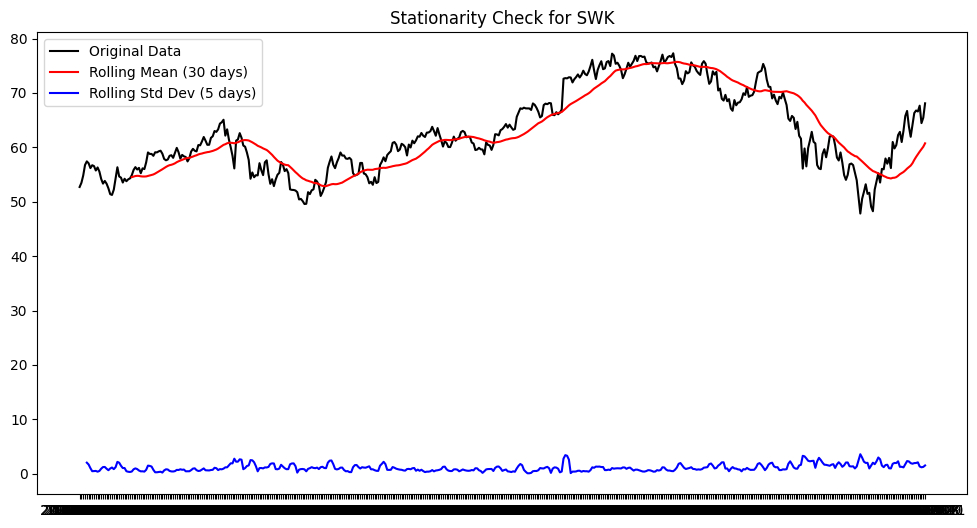

Dickey-Fuller Test: Stationarity Check for SWK

Test Statistic                  -1.604888
p-value                          0.481138
#Lags Used                       3.000000
Number of Observations Used    467.000000
dtype: float64
Critical value at 1%: -3.44443
Critical value at 5%: -2.86775
Critical value at 10%: -2.57008


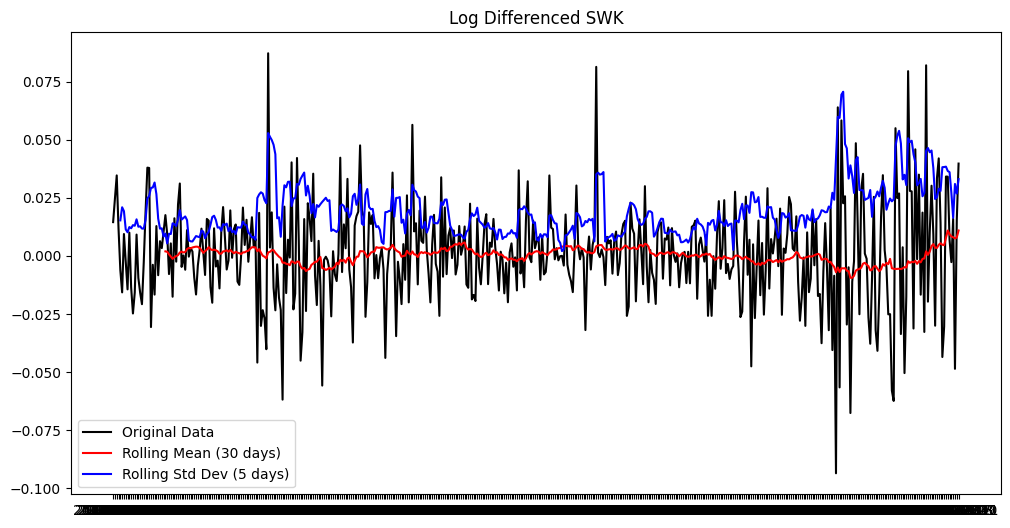

Dickey-Fuller Test: Log Differenced SWK

Test Statistic                -1.497722e+01
p-value                        1.176386e-27
#Lags Used                     2.000000e+00
Number of Observations Used    4.670000e+02
dtype: float64
Critical value at 1%: -3.44443
Critical value at 5%: -2.86775
Critical value at 10%: -2.57008
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  471
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -789.647
Date:                Wed, 22 Nov 2023   AIC                           1583.293
Time:                        09:01:45   BIC                           1591.599
Sample:                             0   HQIC                          1586.561
                                - 471                                         
Covariance Type:                  opg                                         
                 coef    std err          

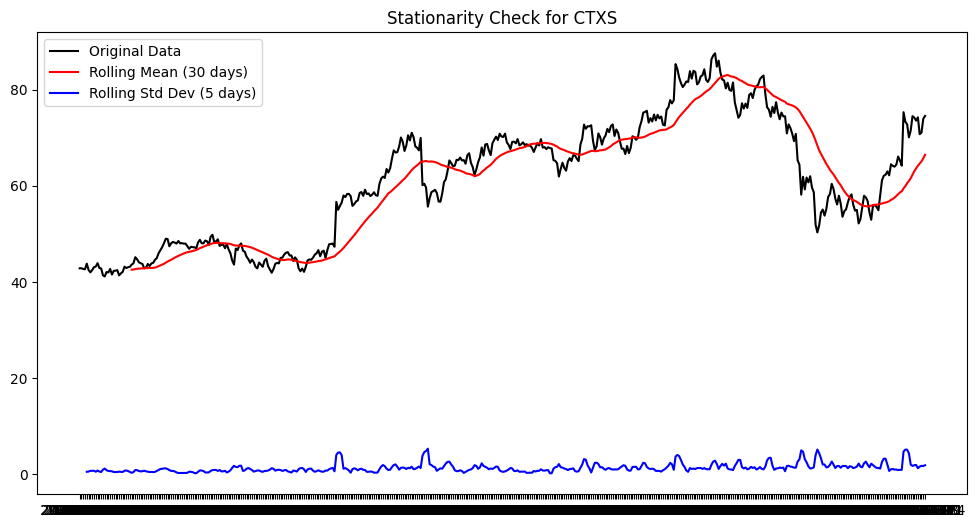

Dickey-Fuller Test: Stationarity Check for CTXS

Test Statistic                  -1.485577
p-value                          0.540634
#Lags Used                       1.000000
Number of Observations Used    470.000000
dtype: float64
Critical value at 1%: -3.44434
Critical value at 5%: -2.86771
Critical value at 10%: -2.57006


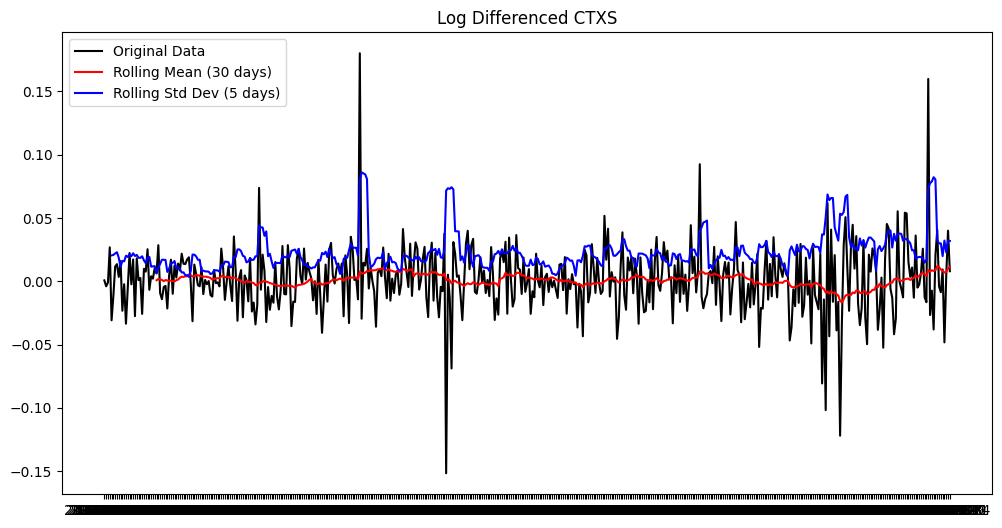

Dickey-Fuller Test: Log Differenced CTXS

Test Statistic                 -23.389894
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    470.000000
dtype: float64
Critical value at 1%: -3.44434
Critical value at 5%: -2.86771
Critical value at 10%: -2.57006
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  472
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -904.182
Date:                Wed, 22 Nov 2023   AIC                           1812.365
Time:                        09:01:50   BIC                           1820.675
Sample:                             0   HQIC                          1815.634
                                - 472                                         
Covariance Type:                  opg                                         
                 coef    std err          z      

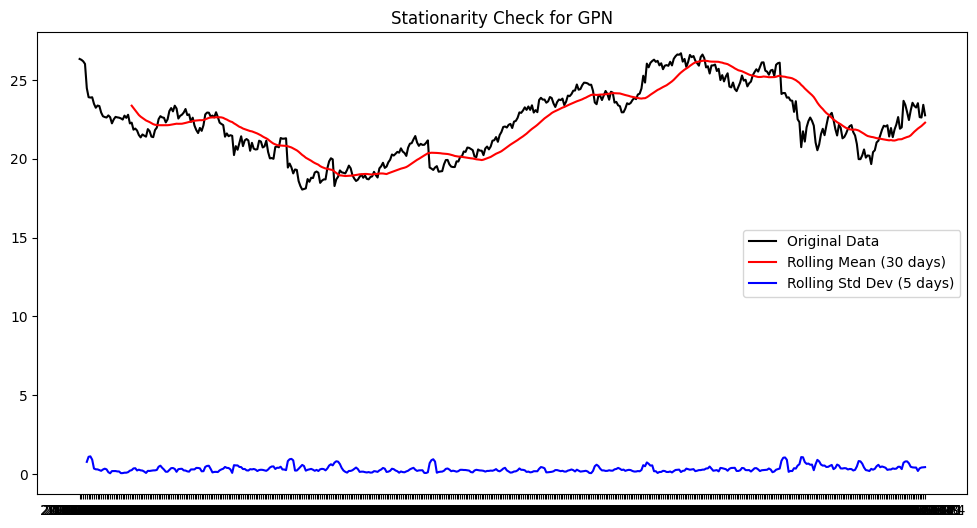

Dickey-Fuller Test: Stationarity Check for GPN

Test Statistic                  -2.11863
p-value                          0.23709
#Lags Used                       3.00000
Number of Observations Used    468.00000
dtype: float64
Critical value at 1%: -3.44440
Critical value at 5%: -2.86774
Critical value at 10%: -2.57007


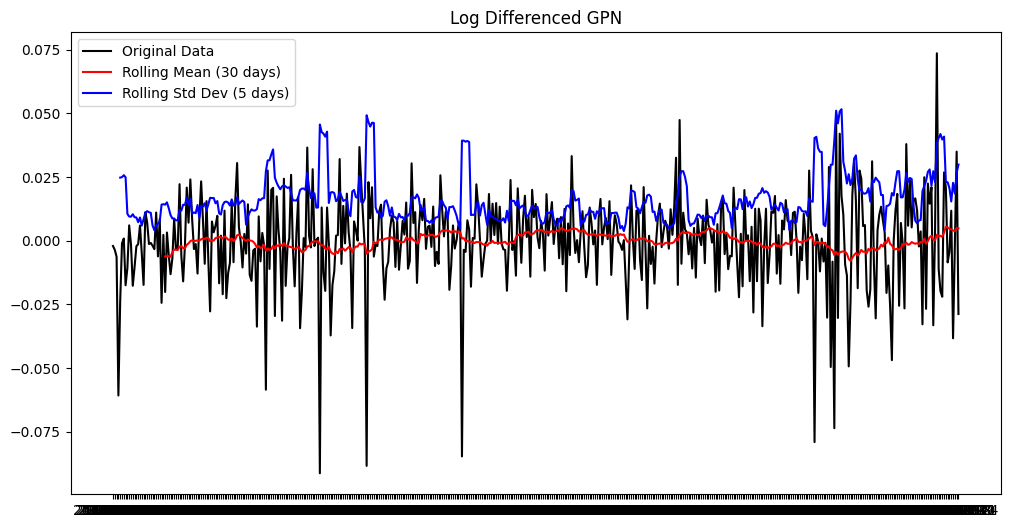

Dickey-Fuller Test: Log Differenced GPN

Test Statistic                -1.400223e+01
p-value                        3.843708e-26
#Lags Used                     2.000000e+00
Number of Observations Used    4.680000e+02
dtype: float64
Critical value at 1%: -3.44440
Critical value at 5%: -2.86774
Critical value at 10%: -2.57007
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  472
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -232.036
Date:                Wed, 22 Nov 2023   AIC                            468.073
Time:                        09:01:58   BIC                            476.383
Sample:                             0   HQIC                           471.342
                                - 472                                         
Covariance Type:                  opg                                         
                 coef    std err          

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")  # Ignore convergence warnings for clarity

warnings.filterwarnings("ignore")
def check_stationarity(ts_data, title):
    # Rolling statistics
    roll_mean = ts_data.rolling(30).mean()
    roll_std = ts_data.rolling(5).std()

    # Plot rolling statistics
    plt.figure(figsize=(12, 6))
    plt.plot(ts_data, color='black', label='Original Data')
    plt.plot(roll_mean, color='red', label='Rolling Mean (30 days)')
    plt.plot(roll_std, color='blue', label='Rolling Std Dev (5 days)')
    plt.legend()
    plt.title(title)
    plt.show()

    # Dickey-Fuller test
    print(f'Dickey-Fuller Test: {title}\n')
    df_test = adfuller(ts_data, autolag='AIC')
    test_result = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    print(test_result)
    for key, value in df_test[4].items():
        print(f'Critical value at {key}: {value:.5f}')
stocks = ['RIG', 'KMB', 'SWK', 'CTXS', 'GPN']

for stock in stocks:
    print(f"\nAnalyzing Stock: {stock}\n{'='*30}")
    stock_data = df[df['symbol'] == stock]['close'].dropna()

    # Checking stationarity
    check_stationarity(stock_data, f'Stationarity Check for {stock}')

    stock_data_log = np.log(stock_data)
    stock_data_log_diff = stock_data_log - stock_data_log.shift()
    stock_data_log_diff.dropna(inplace=True)
    check_stationarity(stock_data_log_diff, f'Log Differenced {stock}')

    # Fit ARIMA Model (example with ARIMA(1,1,0))
    model_ARIMA = ARIMA(stock_data, order=(1, 1, 0))
    model_ARIMA_fit = model_ARIMA.fit()
    print(model_ARIMA_fit.summary())

    # Forecasting (example)
    forecast = model_ARIMA_fit.forecast(steps=5)
    print(f"\nForecast for {stock}: {forecast}\n")


# Build the model using LSTM layers

Processing stock: RIG
Epoch 1/70
2/2 [==============================] - 5s 1s/step - loss: 0.0205 - val_loss: 0.0071
Epoch 2/70
2/2 [==============================] - 1s 318ms/step - loss: 0.0069 - val_loss: 0.0042
Epoch 3/70
2/2 [==============================] - 1s 314ms/step - loss: 0.0072 - val_loss: 0.0036
Epoch 4/70
2/2 [==============================] - 1s 331ms/step - loss: 0.0054 - val_loss: 0.0017
Epoch 5/70
2/2 [==============================] - 1s 317ms/step - loss: 0.0042 - val_loss: 0.0029
Epoch 6/70
2/2 [==============================] - 1s 313ms/step - loss: 0.0050 - val_loss: 0.0028
Epoch 7/70
2/2 [==============================] - 1s 336ms/step - loss: 0.0046 - val_loss: 0.0020
Epoch 8/70
2/2 [==============================] - 1s 316ms/step - loss: 0.0041 - val_loss: 0.0016
Epoch 9/70
2/2 [==============================] - 1s 327ms/step - loss: 0.0041 - val_loss: 0.0017
Epoch 10/70
2/2 [==============================] - 1s 314ms/step - loss: 0.0042 - val_loss: 0.0018


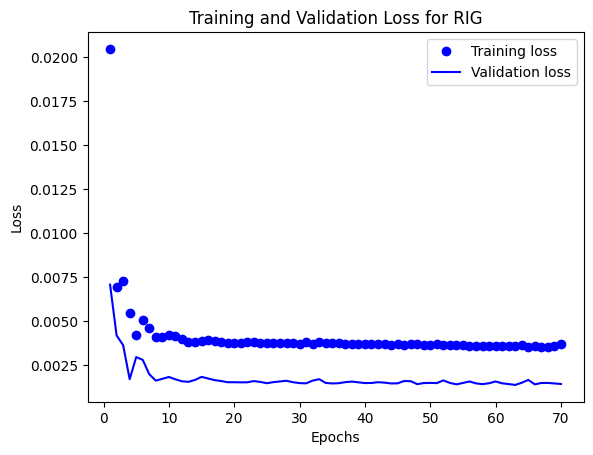

Processing stock: KMB
Epoch 1/70
2/2 [==============================] - 6s 1s/step - loss: 0.0072 - val_loss: 0.0059
Epoch 2/70
2/2 [==============================] - 1s 548ms/step - loss: 0.0031 - val_loss: 0.0067
Epoch 3/70
2/2 [==============================] - 1s 512ms/step - loss: 0.0036 - val_loss: 0.0054
Epoch 4/70
2/2 [==============================] - 1s 522ms/step - loss: 0.0027 - val_loss: 0.0048
Epoch 5/70
2/2 [==============================] - 1s 535ms/step - loss: 0.0026 - val_loss: 0.0052
Epoch 6/70
2/2 [==============================] - 1s 532ms/step - loss: 0.0027 - val_loss: 0.0047
Epoch 7/70
2/2 [==============================] - 1s 522ms/step - loss: 0.0024 - val_loss: 0.0047
Epoch 8/70
2/2 [==============================] - 1s 361ms/step - loss: 0.0023 - val_loss: 0.0049
Epoch 9/70
2/2 [==============================] - 1s 328ms/step - loss: 0.0024 - val_loss: 0.0049
Epoch 10/70
2/2 [==============================] - 1s 327ms/step - loss: 0.0023 - val_loss: 0.0047


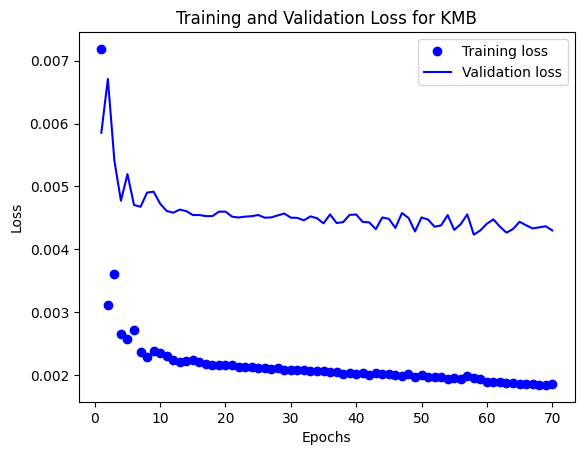

Processing stock: SWK
Epoch 1/70
2/2 [==============================] - 7s 1s/step - loss: 0.0105 - val_loss: 0.0083
Epoch 2/70
2/2 [==============================] - 1s 311ms/step - loss: 0.0046 - val_loss: 0.0085
Epoch 3/70
2/2 [==============================] - 1s 307ms/step - loss: 0.0053 - val_loss: 0.0061
Epoch 4/70
2/2 [==============================] - 1s 338ms/step - loss: 0.0042 - val_loss: 0.0054
Epoch 5/70
2/2 [==============================] - 1s 321ms/step - loss: 0.0041 - val_loss: 0.0069
Epoch 6/70
2/2 [==============================] - 1s 344ms/step - loss: 0.0042 - val_loss: 0.0053
Epoch 7/70
2/2 [==============================] - 1s 314ms/step - loss: 0.0039 - val_loss: 0.0046
Epoch 8/70
2/2 [==============================] - 1s 308ms/step - loss: 0.0037 - val_loss: 0.0053
Epoch 9/70
2/2 [==============================] - 1s 315ms/step - loss: 0.0038 - val_loss: 0.0052
Epoch 10/70
2/2 [==============================] - 1s 321ms/step - loss: 0.0038 - val_loss: 0.0047


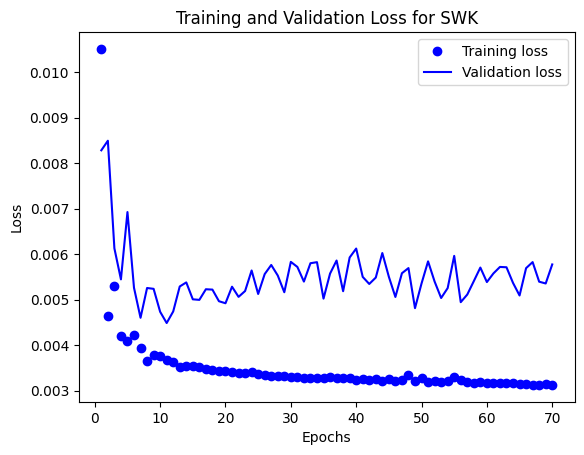

Processing stock: CTXS
Epoch 1/70
2/2 [==============================] - 5s 1s/step - loss: 0.0052 - val_loss: 0.0035
Epoch 2/70
2/2 [==============================] - 1s 339ms/step - loss: 0.0029 - val_loss: 0.0044
Epoch 3/70
2/2 [==============================] - 1s 325ms/step - loss: 0.0034 - val_loss: 0.0028
Epoch 4/70
2/2 [==============================] - 1s 323ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 5/70
2/2 [==============================] - 1s 317ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 6/70
2/2 [==============================] - 1s 331ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 7/70
2/2 [==============================] - 1s 527ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 8/70
2/2 [==============================] - 1s 528ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 9/70
2/2 [==============================] - 1s 502ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 10/70
2/2 [==============================] - 1s 509ms/step - loss: 0.0024 - val_loss: 0.0014

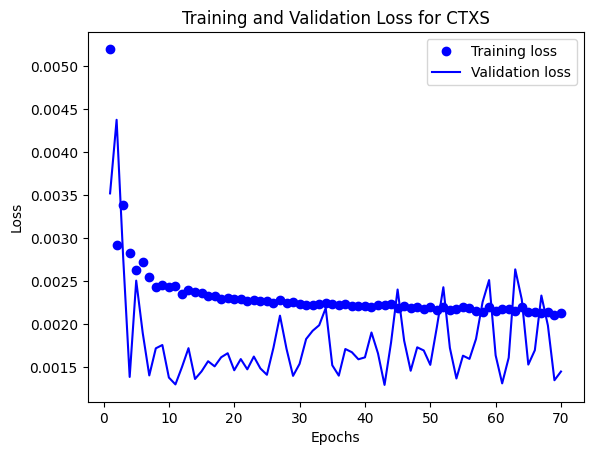

Processing stock: GPN
Epoch 1/70
2/2 [==============================] - 7s 2s/step - loss: 0.0125 - val_loss: 0.0043
Epoch 2/70
2/2 [==============================] - 1s 335ms/step - loss: 0.0057 - val_loss: 0.0031
Epoch 3/70
2/2 [==============================] - 1s 313ms/step - loss: 0.0063 - val_loss: 0.0019
Epoch 4/70
2/2 [==============================] - 1s 325ms/step - loss: 0.0050 - val_loss: 0.0019
Epoch 5/70
2/2 [==============================] - 1s 315ms/step - loss: 0.0048 - val_loss: 0.0036
Epoch 6/70
2/2 [==============================] - 1s 321ms/step - loss: 0.0050 - val_loss: 0.0022
Epoch 7/70
2/2 [==============================] - 1s 313ms/step - loss: 0.0046 - val_loss: 0.0014
Epoch 8/70
2/2 [==============================] - 1s 315ms/step - loss: 0.0045 - val_loss: 0.0016
Epoch 9/70
2/2 [==============================] - 1s 353ms/step - loss: 0.0046 - val_loss: 0.0023
Epoch 10/70
2/2 [==============================] - 1s 310ms/step - loss: 0.0046 - val_loss: 0.0017


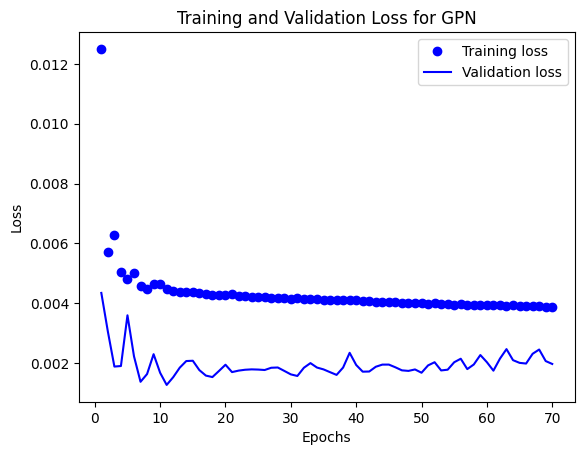

In [12]:
stocks = ['RIG', 'KMB', 'SWK', 'CTXS', 'GPN']
n_epochs = 70  # Adjust as needed
batch_size = 100  # Adjust as needed
n_neurons = 300  # Adjust as needed
n_layers = 2  # Adjust as needed
seq_len = 20  # Adjust as needed
n_inputs = 4  # Number of features, adjust as needed

for stock in stocks:
    print(f"Processing stock: {stock}")

    # Prepare data for the current stock
    df_stock = df[df.symbol == stock].copy()
    df_stock.drop(['symbol'], axis=1, inplace=True)
    df_stock_norm = normalize_data(df_stock)

    # Create train, validation, test data
    x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len, 40, 20, 40)

    # Calculate moving averages for y_train, y_valid, y_test
    y_train_ma = calculate_moving_average(y_train, window_size)
    y_valid_ma = calculate_moving_average(y_valid, window_size)
    y_test_ma = calculate_moving_average(y_test, window_size)

    # Adjust datasets
    y_train_residual = y_train[window_size-1:] - y_train_ma
    y_valid_residual = y_valid[window_size-1:] - y_valid_ma
    y_test_residual = y_test[window_size-1:] - y_test_ma

    x_train_adjusted = x_train[-y_train_residual.shape[0]:, :, :]
    x_valid_adjusted = x_valid[-y_valid_residual.shape[0]:, :, :]
    x_test_adjusted = x_test[-y_test_residual.shape[0]:, :, :]

    # Build and compile the LSTM model
    model_LSTM = tf.keras.Sequential()
    for i in range(n_layers - 1):
        model_LSTM.add(tf.keras.layers.LSTM(n_neurons, return_sequences=True, activation='tanh', recurrent_activation='sigmoid'))
    model_LSTM.add(tf.keras.layers.LSTM(n_neurons, return_sequences=False, activation='tanh', recurrent_activation='sigmoid'))
    model_LSTM.add(tf.keras.layers.Dense(5))  # Assuming 5 output features

    model_LSTM.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    history_LSTM = model_LSTM.fit(
        x_train_adjusted, y_train_residual,
        epochs=n_epochs,
        batch_size=batch_size,
        validation_data=(x_valid_adjusted, y_valid_residual)
    )

    # Make predictions
    y_train_pred_residual_LSTM = model_LSTM.predict(x_train_adjusted)
    y_valid_pred_residual_LSTM = model_LSTM.predict(x_valid_adjusted)
    y_test_pred_residual_LSTM = model_LSTM.predict(x_test_adjusted)

    # Calculate final predictions
    y_train_final_pred_LSTM = y_train_ma + y_train_pred_residual_LSTM[:y_train_ma.shape[0], :]
    y_valid_final_pred_LSTM = y_valid_ma + y_valid_pred_residual_LSTM[:y_valid_ma.shape[0], :]
    y_test_final_pred_LSTM = y_test_ma + y_test_pred_residual_LSTM[:y_test_ma.shape[0], :]

    # Plot training and validation loss
    loss = history_LSTM.history['loss']
    val_loss = history_LSTM.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(f'Training and Validation Loss for {stock}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


Training on stock: RIG
Epoch 1/70
2/2 [==============================] - 6s 2s/step - loss: 0.0164 - val_loss: 0.0033
Epoch 2/70
2/2 [==============================] - 1s 500ms/step - loss: 0.0052 - val_loss: 0.0025
Epoch 3/70
2/2 [==============================] - 1s 495ms/step - loss: 0.0048 - val_loss: 0.0018
Epoch 4/70
2/2 [==============================] - 1s 503ms/step - loss: 0.0042 - val_loss: 0.0020
Epoch 5/70
2/2 [==============================] - 1s 494ms/step - loss: 0.0045 - val_loss: 0.0021
Epoch 6/70
2/2 [==============================] - 1s 835ms/step - loss: 0.0042 - val_loss: 0.0016
Epoch 7/70
2/2 [==============================] - 2s 803ms/step - loss: 0.0040 - val_loss: 0.0017
Epoch 8/70
2/2 [==============================] - 2s 792ms/step - loss: 0.0041 - val_loss: 0.0018
Epoch 9/70
2/2 [==============================] - 2s 933ms/step - loss: 0.0041 - val_loss: 0.0017
Epoch 10/70
2/2 [==============================] - 2s 816ms/step - loss: 0.0040 - val_loss: 0.0015

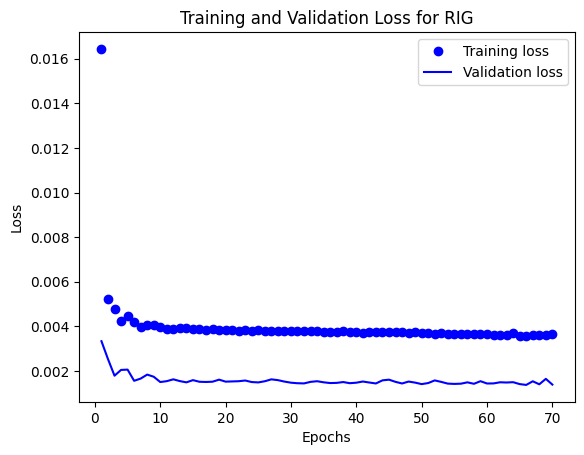

Training on stock: KMB
Epoch 1/70
2/2 [==============================] - 7s 1s/step - loss: 0.0062 - val_loss: 0.0054
Epoch 2/70
2/2 [==============================] - 1s 501ms/step - loss: 0.0026 - val_loss: 0.0054
Epoch 3/70
2/2 [==============================] - 1s 644ms/step - loss: 0.0026 - val_loss: 0.0047
Epoch 4/70
2/2 [==============================] - 2s 809ms/step - loss: 0.0024 - val_loss: 0.0049
Epoch 5/70
2/2 [==============================] - 2s 810ms/step - loss: 0.0025 - val_loss: 0.0048
Epoch 6/70
2/2 [==============================] - 2s 830ms/step - loss: 0.0023 - val_loss: 0.0047
Epoch 7/70
2/2 [==============================] - 2s 793ms/step - loss: 0.0023 - val_loss: 0.0048
Epoch 8/70
2/2 [==============================] - 1s 519ms/step - loss: 0.0023 - val_loss: 0.0048
Epoch 9/70
2/2 [==============================] - 1s 541ms/step - loss: 0.0023 - val_loss: 0.0047
Epoch 10/70
2/2 [==============================] - 1s 514ms/step - loss: 0.0023 - val_loss: 0.0047

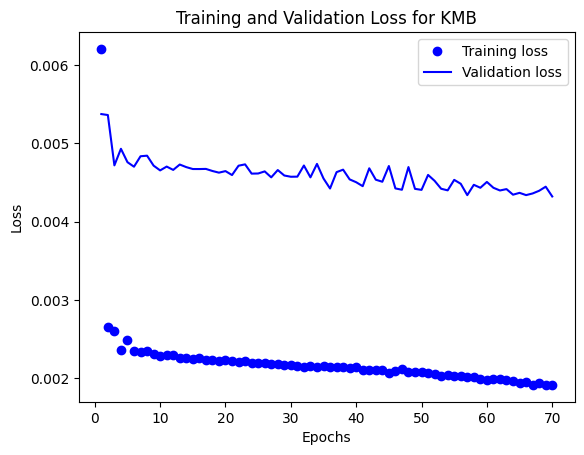

Training on stock: SWK
Epoch 1/70
2/2 [==============================] - 7s 2s/step - loss: 0.0094 - val_loss: 0.0061
Epoch 2/70
2/2 [==============================] - 2s 845ms/step - loss: 0.0041 - val_loss: 0.0062
Epoch 3/70
2/2 [==============================] - 1s 773ms/step - loss: 0.0042 - val_loss: 0.0048
Epoch 4/70
2/2 [==============================] - 2s 830ms/step - loss: 0.0041 - val_loss: 0.0061
Epoch 5/70
2/2 [==============================] - 2s 786ms/step - loss: 0.0040 - val_loss: 0.0054
Epoch 6/70
2/2 [==============================] - 1s 498ms/step - loss: 0.0038 - val_loss: 0.0050
Epoch 7/70
2/2 [==============================] - 1s 489ms/step - loss: 0.0039 - val_loss: 0.0049
Epoch 8/70
2/2 [==============================] - 1s 492ms/step - loss: 0.0038 - val_loss: 0.0049
Epoch 9/70
2/2 [==============================] - 1s 502ms/step - loss: 0.0037 - val_loss: 0.0050
Epoch 10/70
2/2 [==============================] - 1s 491ms/step - loss: 0.0037 - val_loss: 0.0050

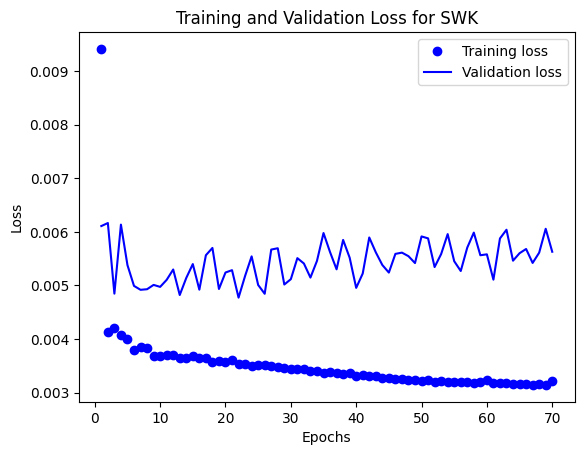

Training on stock: CTXS
Epoch 1/70
2/2 [==============================] - 9s 3s/step - loss: 0.0045 - val_loss: 0.0024
Epoch 2/70
2/2 [==============================] - 1s 541ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 3/70
2/2 [==============================] - 1s 524ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 4/70
2/2 [==============================] - 1s 511ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 5/70
2/2 [==============================] - 1s 485ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 6/70
2/2 [==============================] - 1s 497ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 7/70
2/2 [==============================] - 1s 505ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 8/70
2/2 [==============================] - 1s 513ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 9/70
2/2 [==============================] - 1s 501ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 10/70
2/2 [==============================] - 1s 508ms/step - loss: 0.0025 - val_loss: 0.001

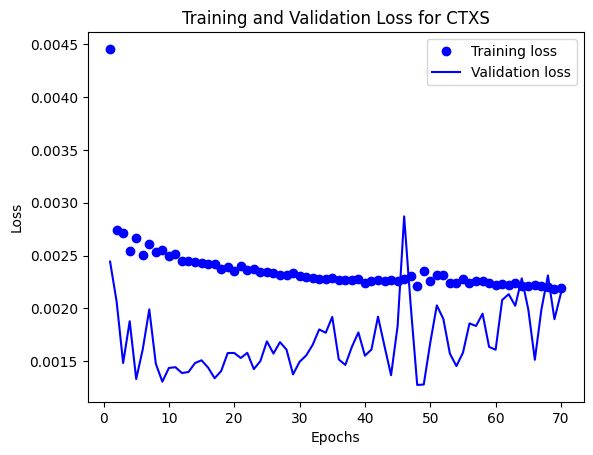

Training on stock: GPN
Epoch 1/70
2/2 [==============================] - 6s 2s/step - loss: 0.0138 - val_loss: 0.0027
Epoch 2/70
2/2 [==============================] - 1s 509ms/step - loss: 0.0054 - val_loss: 0.0019
Epoch 3/70
2/2 [==============================] - 1s 502ms/step - loss: 0.0052 - val_loss: 0.0016
Epoch 4/70
2/2 [==============================] - 1s 501ms/step - loss: 0.0050 - val_loss: 0.0015
Epoch 5/70
2/2 [==============================] - 1s 508ms/step - loss: 0.0050 - val_loss: 0.0014
Epoch 6/70
2/2 [==============================] - 1s 755ms/step - loss: 0.0048 - val_loss: 0.0013
Epoch 7/70
2/2 [==============================] - 2s 859ms/step - loss: 0.0047 - val_loss: 0.0014
Epoch 8/70
2/2 [==============================] - 2s 939ms/step - loss: 0.0048 - val_loss: 0.0014
Epoch 9/70
2/2 [==============================] - 2s 943ms/step - loss: 0.0047 - val_loss: 0.0015
Epoch 10/70
2/2 [==============================] - 2s 924ms/step - loss: 0.0046 - val_loss: 0.0015

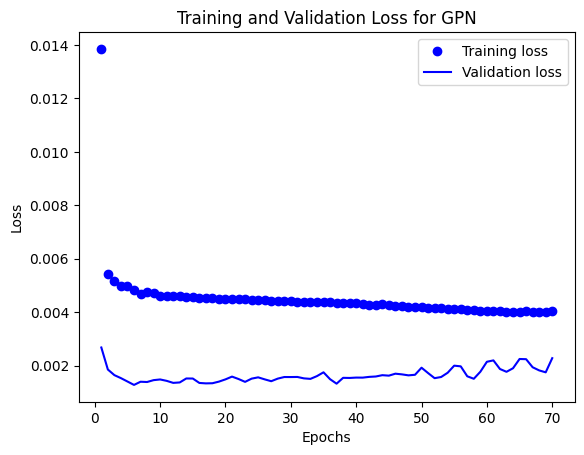

In [13]:
stocks = ['RIG', 'KMB', 'SWK', 'CTXS', 'GPN']
n_epochs = 70  # Adjust as needed
batch_size = 100  # Adjust as needed
n_neurons = 300  # Number of neurons in LSTM layers
n_inputs = 5    # Number of features; adjust as needed
n_outputs = 5   # Assuming 5 output features
seq_len = 20    # Sequence length for your LSTM model

for stock in stocks:
    print(f"Training on stock: {stock}")

    # Filter the DataFrame for the current stock
    df_stock = df[df['symbol'] == stock].copy()
    df_stock.drop(['symbol'], axis=1, inplace=True)
    df_stock_norm = normalize_data(df_stock)

    # Create train, validation, test data
    x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len, 40, 20, 40)

    # Calculate moving averages for y_train, y_valid, y_test
    y_train_ma = calculate_moving_average(y_train, window_size)
    y_valid_ma = calculate_moving_average(y_valid, window_size)
    y_test_ma = calculate_moving_average(y_test, window_size)

    # Adjust datasets
    y_train_adjusted = y_train[window_size-1:] - y_train_ma
    y_valid_adjusted = y_valid[window_size-1:] - y_valid_ma
    y_test_adjusted = y_test[window_size-1:] - y_test_ma

    x_train_adjusted = x_train[-y_train_adjusted.shape[0]:, :, :]
    x_valid_adjusted = x_valid[-y_valid_adjusted.shape[0]:, :, :]
    x_test_adjusted = x_test[-y_test_adjusted.shape[0]:, :, :]

    # Define the LSTM model
    model_LSTM = tf.keras.Sequential([
        tf.keras.layers.LSTM(n_neurons, return_sequences=True, input_shape=(x_train_adjusted.shape[1], n_inputs)),
        tf.keras.layers.LSTM(n_neurons, return_sequences=True),
        tf.keras.layers.LSTM(n_neurons, return_sequences=False),
        tf.keras.layers.Dense(5)
    ])

    # Compile the model
    model_LSTM.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    history_LSTM = model_LSTM.fit(
        x_train_adjusted, y_train_adjusted,
        epochs=n_epochs,
        batch_size=batch_size,
        validation_data=(x_valid_adjusted, y_valid_adjusted)
    )

    # Make predictions
    y_train_pred_LSTM = model_LSTM.predict(x_train_adjusted)
    y_valid_pred_LSTM = model_LSTM.predict(x_valid_adjusted)
    y_test_pred_LSTM = model_LSTM.predict(x_test_adjusted)

    # Calculate final predictions
    y_train_final_pred_LSTM = y_train_ma + y_train_pred_LSTM[-y_train_ma.shape[0]:]
    y_valid_final_pred_LSTM = y_valid_ma + y_valid_pred_LSTM[-y_valid_ma.shape[0]:]
    y_test_final_pred_LSTM = y_test_ma + y_test_pred_LSTM[-y_test_ma.shape[0]:]

    # Plot training and validation loss
    loss = history_LSTM.history['loss']
    val_loss = history_LSTM.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(f'Training and Validation Loss for {stock}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


# use GRU cell

Training on stock: RIG
Epoch 1/70
2/2 [==============================] - 5s 895ms/step - loss: 0.0215 - val_loss: 0.0087
Epoch 2/70
2/2 [==============================] - 0s 247ms/step - loss: 0.0083 - val_loss: 0.0102
Epoch 3/70
2/2 [==============================] - 0s 266ms/step - loss: 0.0121 - val_loss: 0.0085
Epoch 4/70
2/2 [==============================] - 0s 242ms/step - loss: 0.0080 - val_loss: 0.0017
Epoch 5/70
2/2 [==============================] - 0s 269ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 6/70
2/2 [==============================] - 0s 254ms/step - loss: 0.0064 - val_loss: 0.0040
Epoch 7/70
2/2 [==============================] - 0s 251ms/step - loss: 0.0059 - val_loss: 0.0022
Epoch 8/70
2/2 [==============================] - 0s 252ms/step - loss: 0.0042 - val_loss: 0.0017
Epoch 9/70
2/2 [==============================] - 0s 255ms/step - loss: 0.0038 - val_loss: 0.0021
Epoch 10/70
2/2 [==============================] - 0s 248ms/step - loss: 0.0042 - val_loss: 0.0

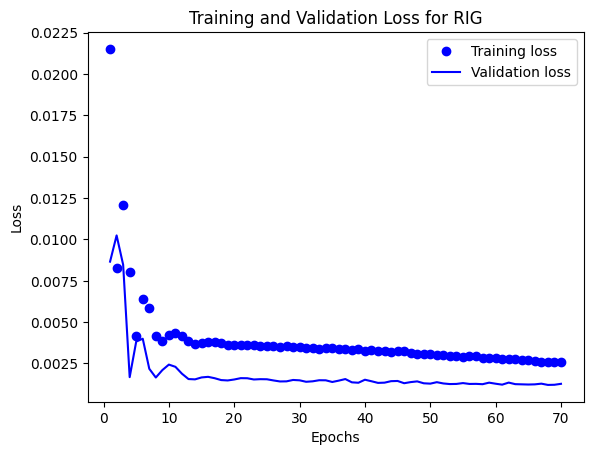

Training on stock: KMB
Epoch 1/70
2/2 [==============================] - 7s 1s/step - loss: 0.0107 - val_loss: 0.0074
Epoch 2/70
2/2 [==============================] - 1s 260ms/step - loss: 0.0042 - val_loss: 0.0082
Epoch 3/70
2/2 [==============================] - 0s 261ms/step - loss: 0.0056 - val_loss: 0.0069
Epoch 4/70
2/2 [==============================] - 0s 247ms/step - loss: 0.0036 - val_loss: 0.0046
Epoch 5/70
2/2 [==============================] - 0s 269ms/step - loss: 0.0025 - val_loss: 0.0057
Epoch 6/70
2/2 [==============================] - 0s 253ms/step - loss: 0.0033 - val_loss: 0.0057
Epoch 7/70
2/2 [==============================] - 0s 264ms/step - loss: 0.0031 - val_loss: 0.0049
Epoch 8/70
2/2 [==============================] - 0s 257ms/step - loss: 0.0024 - val_loss: 0.0045
Epoch 9/70
2/2 [==============================] - 0s 249ms/step - loss: 0.0022 - val_loss: 0.0046
Epoch 10/70
2/2 [==============================] - 0s 266ms/step - loss: 0.0023 - val_loss: 0.0047

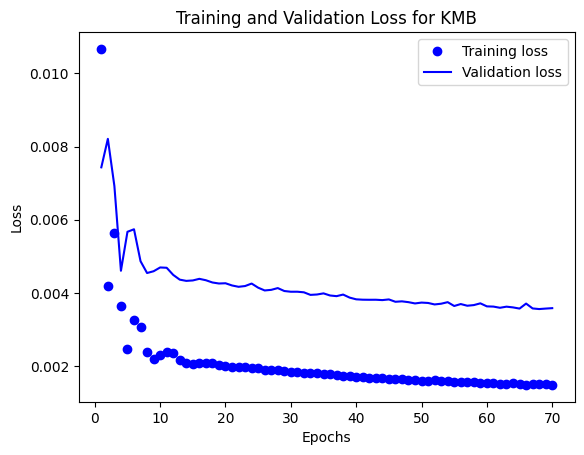

Training on stock: SWK
Epoch 1/70
2/2 [==============================] - 6s 1s/step - loss: 0.0113 - val_loss: 0.0089
Epoch 2/70
2/2 [==============================] - 1s 410ms/step - loss: 0.0054 - val_loss: 0.0156
Epoch 3/70
2/2 [==============================] - 1s 448ms/step - loss: 0.0079 - val_loss: 0.0103
Epoch 4/70
2/2 [==============================] - 1s 424ms/step - loss: 0.0048 - val_loss: 0.0057
Epoch 5/70
2/2 [==============================] - 1s 423ms/step - loss: 0.0039 - val_loss: 0.0072
Epoch 6/70
2/2 [==============================] - 1s 492ms/step - loss: 0.0048 - val_loss: 0.0073
Epoch 7/70
2/2 [==============================] - 1s 424ms/step - loss: 0.0044 - val_loss: 0.0054
Epoch 8/70
2/2 [==============================] - 1s 420ms/step - loss: 0.0036 - val_loss: 0.0050
Epoch 9/70
2/2 [==============================] - 1s 436ms/step - loss: 0.0036 - val_loss: 0.0050
Epoch 10/70
2/2 [==============================] - 1s 263ms/step - loss: 0.0037 - val_loss: 0.0050

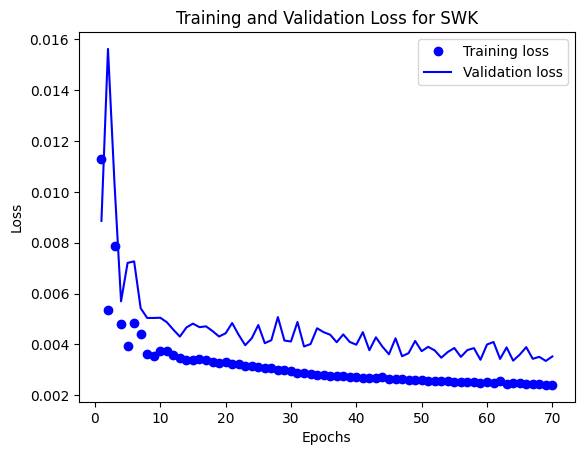

Training on stock: CTXS
Epoch 1/70
2/2 [==============================] - 5s 909ms/step - loss: 0.0066 - val_loss: 0.0069
Epoch 2/70
2/2 [==============================] - 0s 258ms/step - loss: 0.0036 - val_loss: 0.0086
Epoch 3/70
2/2 [==============================] - 0s 273ms/step - loss: 0.0050 - val_loss: 0.0046
Epoch 4/70
2/2 [==============================] - 0s 262ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 5/70
2/2 [==============================] - 0s 259ms/step - loss: 0.0026 - val_loss: 0.0037
Epoch 6/70
2/2 [==============================] - 0s 265ms/step - loss: 0.0030 - val_loss: 0.0035
Epoch 7/70
2/2 [==============================] - 0s 263ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 8/70
2/2 [==============================] - 0s 266ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 9/70
2/2 [==============================] - 0s 267ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 10/70
2/2 [==============================] - 0s 251ms/step - loss: 0.0024 - val_loss: 0.

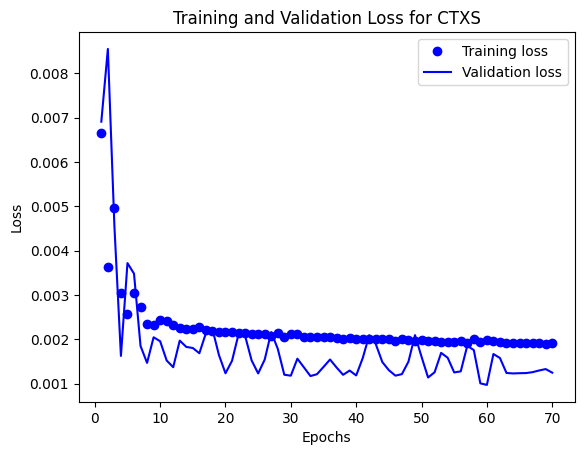

Training on stock: GPN
Epoch 1/70
2/2 [==============================] - 7s 1s/step - loss: 0.0127 - val_loss: 0.0048
Epoch 2/70
2/2 [==============================] - 1s 327ms/step - loss: 0.0060 - val_loss: 0.0047
Epoch 3/70
2/2 [==============================] - 0s 266ms/step - loss: 0.0068 - val_loss: 0.0054
Epoch 4/70
2/2 [==============================] - 0s 267ms/step - loss: 0.0057 - val_loss: 0.0027
Epoch 5/70
2/2 [==============================] - 1s 289ms/step - loss: 0.0044 - val_loss: 0.0031
Epoch 6/70
2/2 [==============================] - 0s 270ms/step - loss: 0.0050 - val_loss: 0.0029
Epoch 7/70
2/2 [==============================] - 0s 255ms/step - loss: 0.0051 - val_loss: 0.0033
Epoch 8/70
2/2 [==============================] - 0s 267ms/step - loss: 0.0044 - val_loss: 0.0024
Epoch 9/70
2/2 [==============================] - 0s 253ms/step - loss: 0.0042 - val_loss: 0.0020
Epoch 10/70
2/2 [==============================] - 0s 251ms/step - loss: 0.0043 - val_loss: 0.0025

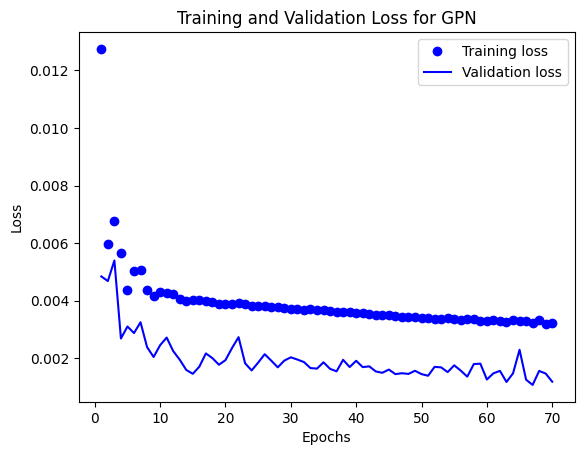

In [14]:
stocks = ['RIG', 'KMB', 'SWK', 'CTXS', 'GPN']
n_epochs = 70  # Adjust as needed
batch_size = 100  # Adjust as needed
n_neurons = 300  # Number of neurons in GRU layers
n_layers = 2     # Number of GRU layers
n_inputs = 4     # Number of features; adjust as needed
n_outputs = 5    # Assuming 5 output features
seq_len = 20     # Sequence length for your GRU model

for stock in stocks:
    print(f"Training on stock: {stock}")

    # Filter the DataFrame for the current stock
    df_stock = df[df['symbol'] == stock].copy()
    df_stock.drop(['symbol'], axis=1, inplace=True)
    df_stock_norm = normalize_data(df_stock)

    # Create train, validation, test data
    x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len, 40, 20, 40)

    # Calculate moving averages for y_train, y_valid, y_test
    y_train_ma = calculate_moving_average(y_train, window_size)
    y_valid_ma = calculate_moving_average(y_valid, window_size)
    y_test_ma = calculate_moving_average(y_test, window_size)

    # Adjust datasets
    y_train_residual = y_train[window_size-1:] - y_train_ma
    y_valid_residual = y_valid[window_size-1:] - y_valid_ma
    y_test_residual = y_test[window_size-1:] - y_test_ma

    x_train_adjusted = x_train[-y_train_residual.shape[0]:, :, :]
    x_valid_adjusted = x_valid[-y_valid_residual.shape[0]:, :, :]
    x_test_adjusted = x_test[-y_test_residual.shape[0]:, :, :]

    # Define the GRU model
    model_GRU = tf.keras.Sequential()
    for _ in range(n_layers - 1):
        model_GRU.add(tf.keras.layers.GRU(n_neurons, return_sequences=True, activation='tanh'))
    model_GRU.add(tf.keras.layers.GRU(n_neurons, activation='tanh'))  # Last layer does not return sequences
    model_GRU.add(tf.keras.layers.Dense(n_outputs))

    # Compile the model
    model_GRU.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    history_GRU = model_GRU.fit(
        x_train_adjusted, y_train_residual,
        epochs=n_epochs,
        batch_size=batch_size,
        validation_data=(x_valid_adjusted, y_valid_residual)
    )

    # Make predictions
    y_train_pred_residual_GRU = model_GRU.predict(x_train_adjusted)
    y_valid_pred_residual_GRU = model_GRU.predict(x_valid_adjusted)
    y_test_pred_residual_GRU = model_GRU.predict(x_test_adjusted)

    # Calculate final predictions
    y_train_final_pred_GRU = y_train_ma + y_train_pred_residual_GRU
    y_valid_final_pred_GRU = y_valid_ma + y_valid_pred_residual_GRU
    y_test_final_pred_GRU = y_test_ma + y_test_pred_residual_GRU

    # Plot training and validation loss
    loss = history_GRU.history['loss']
    val_loss = history_GRU.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(f'Training and Validation Loss for {stock}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


# 5. Predictions <a class="anchor" id="5-bullet"></a>

In [15]:
y_train.shape

(181, 5)

6/6 [==============================] - 0s 7ms/step


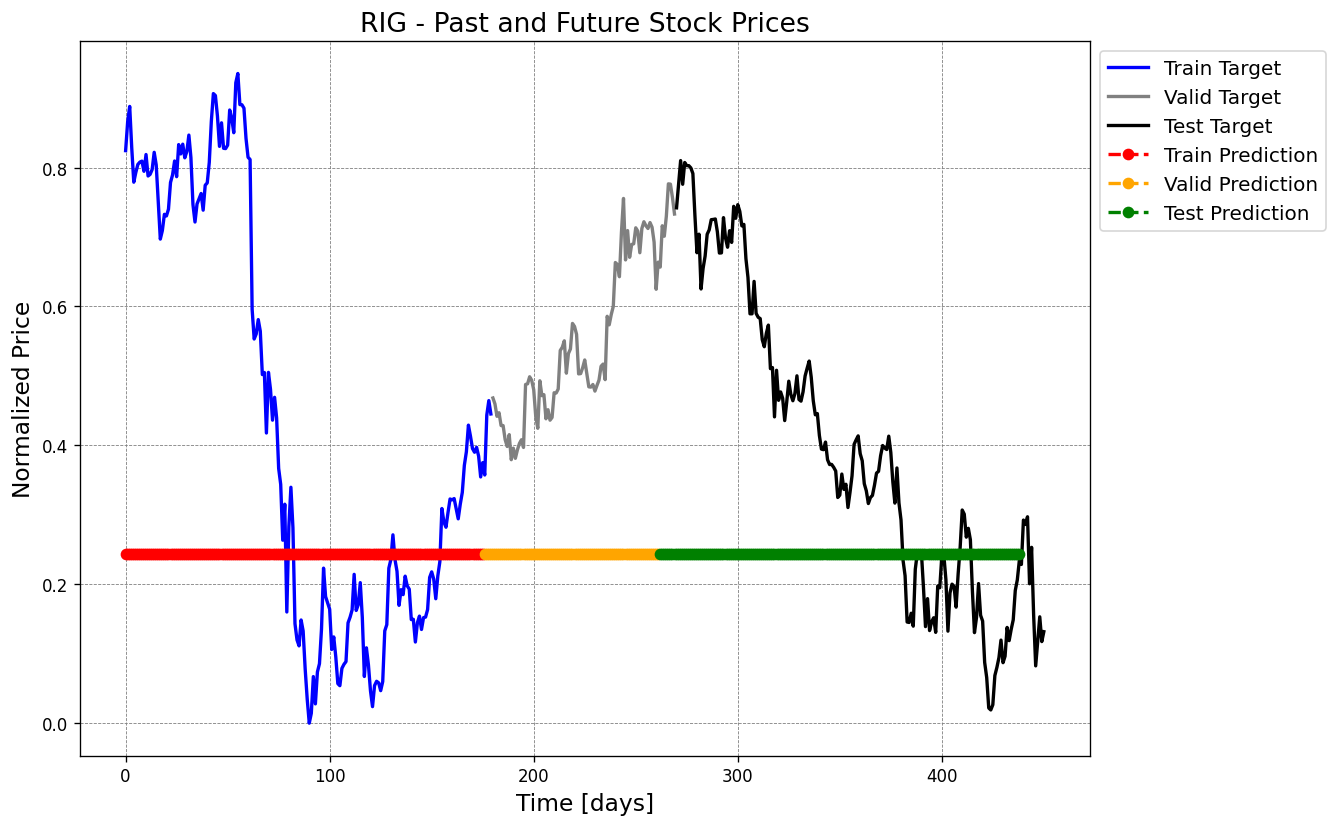

RIG - Correct sign prediction for close - open price for train/valid/test: 0.84/0.95/0.88
6/6 [==============================] - 0s 7ms/step


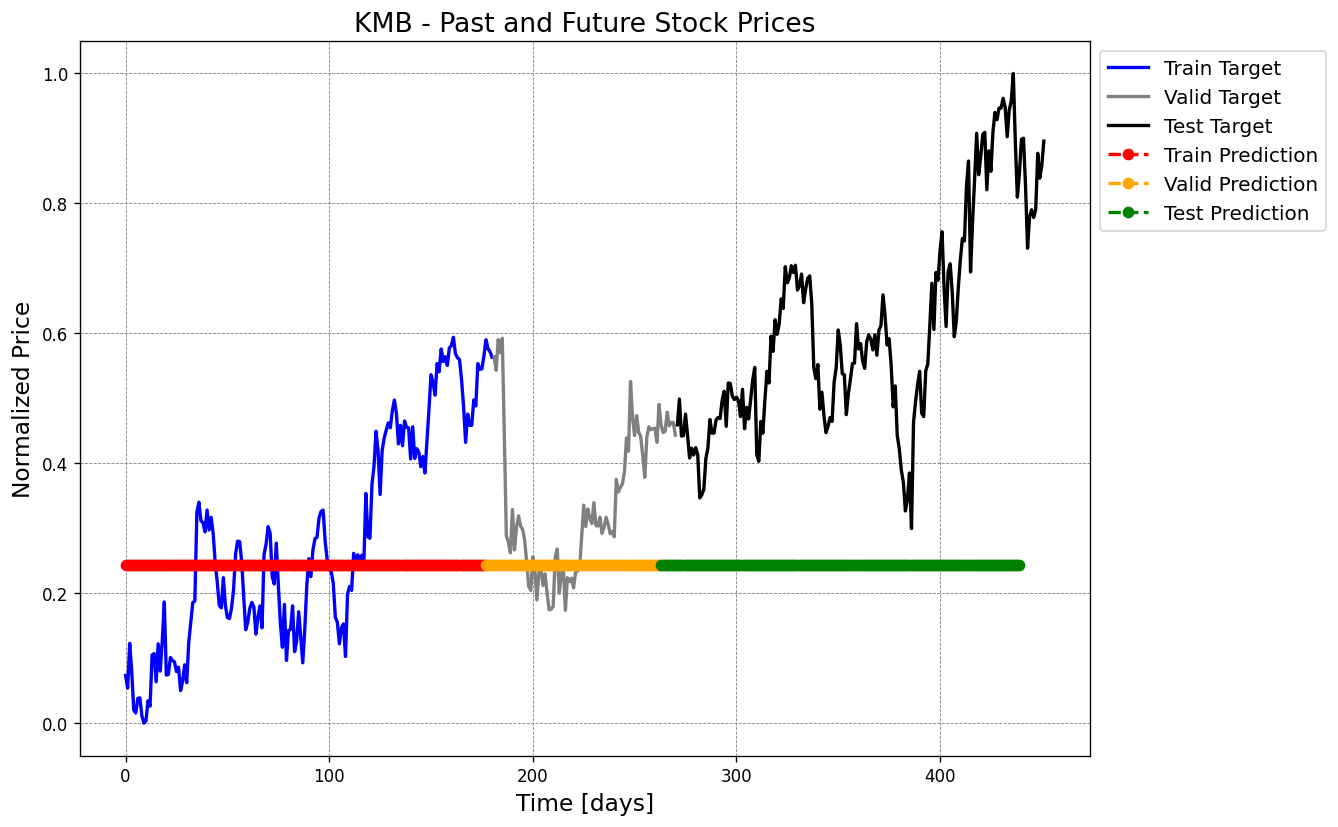

KMB - Correct sign prediction for close - open price for train/valid/test: 0.41/0.28/0.22
6/6 [==============================] - 0s 7ms/step


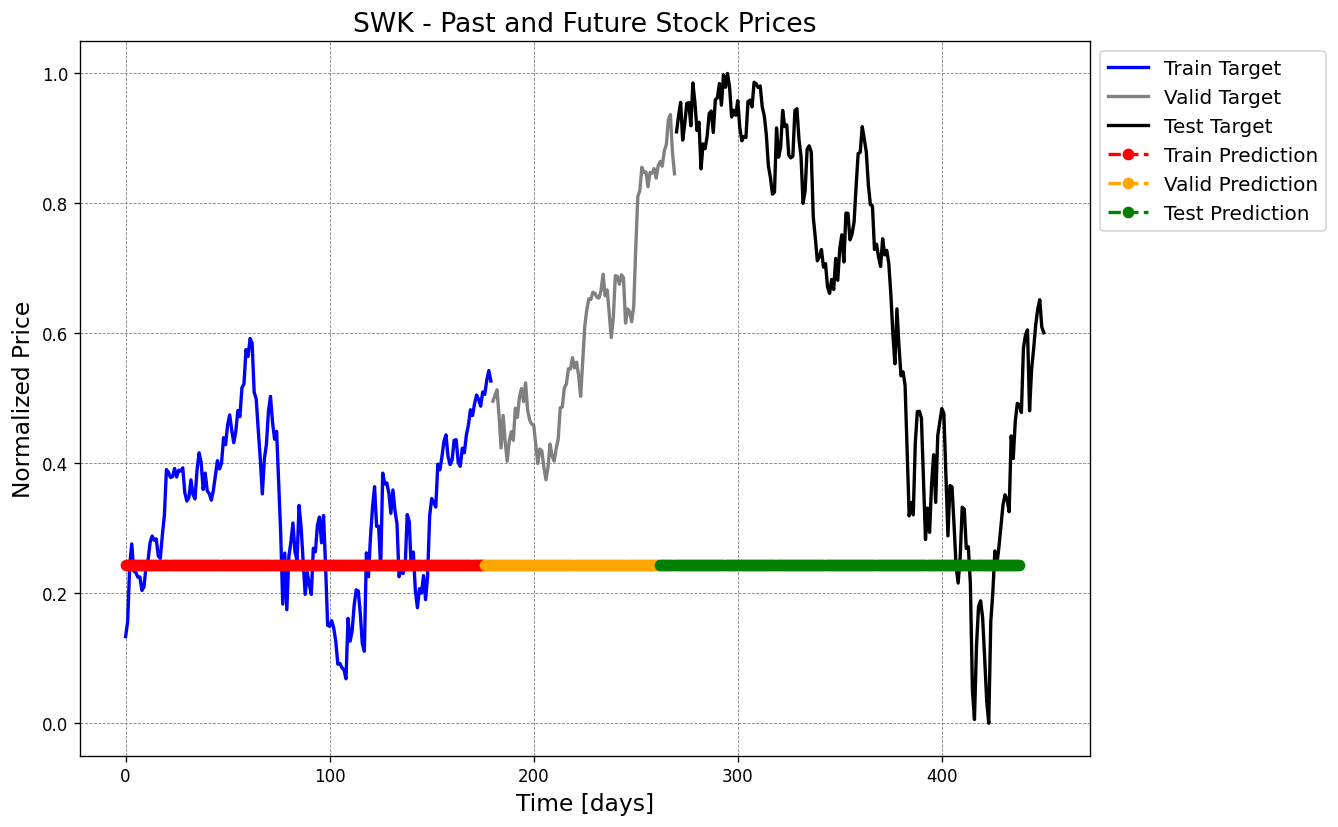

SWK - Correct sign prediction for close - open price for train/valid/test: 0.43/0.57/0.45
6/6 [==============================] - 0s 7ms/step


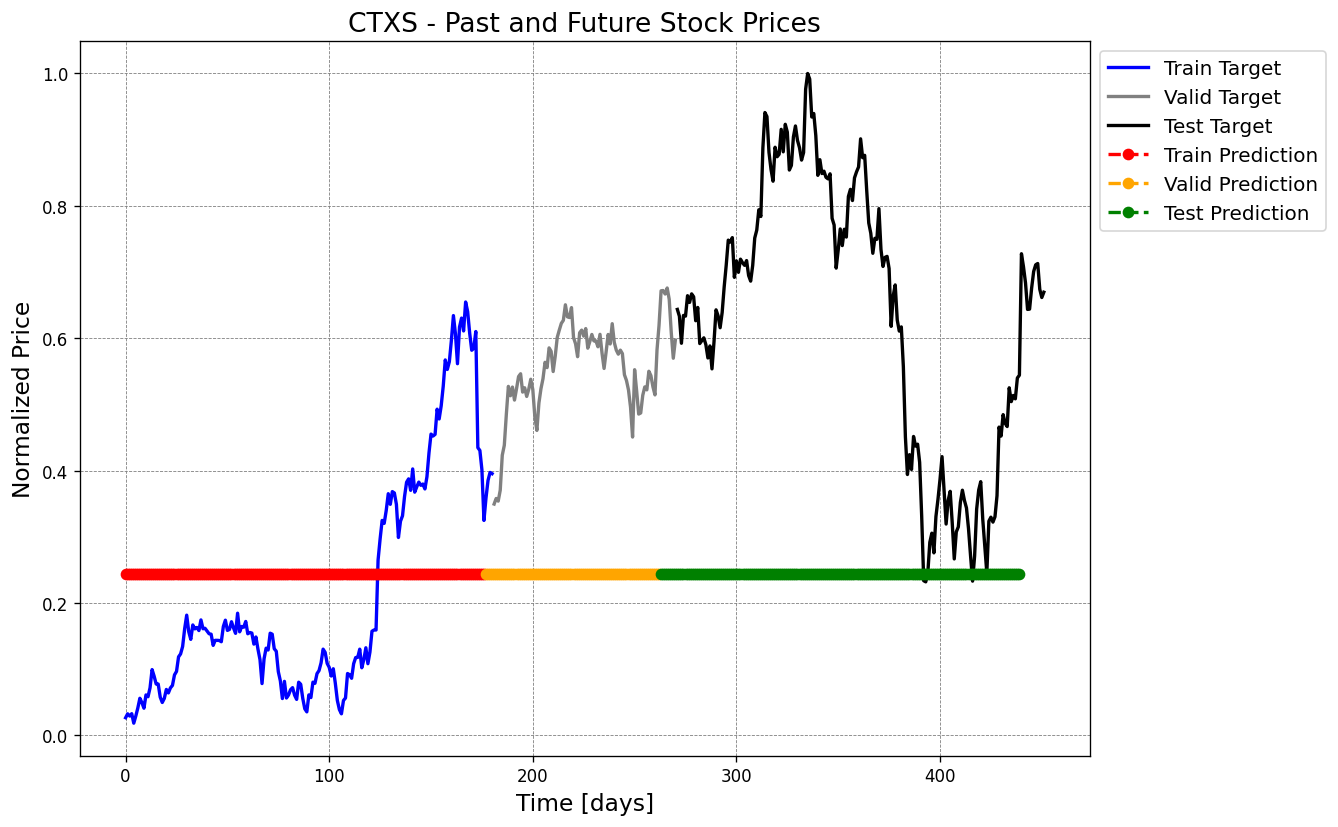

CTXS - Correct sign prediction for close - open price for train/valid/test: 0.32/0.44/0.44
6/6 [==============================] - 0s 9ms/step


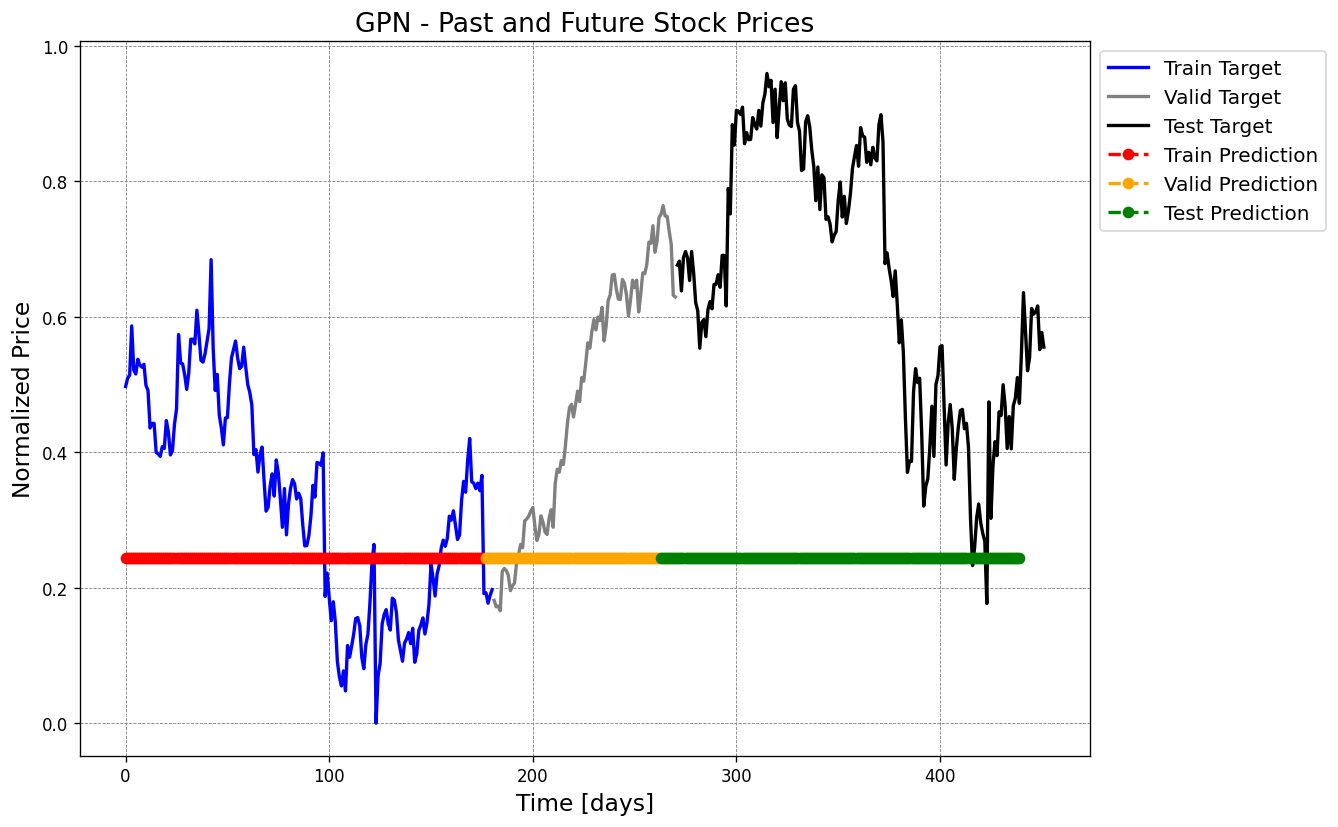

GPN - Correct sign prediction for close - open price for train/valid/test: 0.32/0.56/0.69


In [95]:
stocks = ['RIG', 'KMB', 'SWK', 'CTXS', 'GPN']
seq_len = 20 # Assuming this is your sequence length
window_size = 5  # Assuming this is your window size for moving averages

for stock in stocks:
    # Filter and normalize the data for the current stock
    df_stock = df[df['symbol'] == stock].copy()
    df_stock.drop(['symbol'], axis=1, inplace=True)
    df_stock_norm = normalize_data(df_stock)

    # Create train, validation, test data
    x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len, 40, 20, 40)

    # Calculate moving averages for y_train, y_valid, y_test
    y_train_ma = calculate_moving_average(y_train, window_size)
    y_valid_ma = calculate_moving_average(y_valid, window_size)
    y_test_ma = calculate_moving_average(y_test, window_size)

    # Adjust datasets
    y_train_residual = y_train[window_size-1:] - y_train_ma
    y_valid_residual = y_valid[window_size-1:] - y_valid_ma
    y_test_residual = y_test[window_size-1:] - y_test_ma

    x_train_adjusted = x_train[-y_train_residual.shape[0]:, :, :]
    x_valid_adjusted = x_valid[-y_valid_residual.shape[0]:, :, :]
    x_test_adjusted = x_test[-y_test_residual.shape[0]:, :, :]

    # Assuming you have a model for each stock and it's already trained
    # For example: model = your_model_for_stock(stock)
    # Here, replace with your model prediction logic
    y_train_final_pred = model_RNNs.predict(x_train_adjusted)
    y_valid_final_pred = model_RNNs.predict(x_valid_adjusted)
    y_test_final_pred = model_RNNs.predict(x_test_adjusted)

    # Plotting predictions and actual values
    ft = 0
    # Improved plotting code
    plt.figure(figsize=(15, 7), dpi=120)  # Adjusting size and resolution
    plt.plot(y_train[:, ft], color='blue', label='Train Target', linewidth=2, linestyle='-')
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_valid)), y_valid[:, ft], color='gray', label='Valid Target', linewidth=2, linestyle='-')
    plt.plot(np.arange(len(y_train) + len(y_valid), len(y_train) + len(y_valid) + len(y_test)), y_test[:, ft], color='black', label='Test Target', linewidth=2, linestyle='-')
    plt.plot(y_train_final_pred[:, ft], color='red', linestyle='--', label='Train Prediction', linewidth=2, marker='o')
    plt.plot(np.arange(len(y_train_final_pred), len(y_train_final_pred) + len(y_valid_final_pred)), y_valid_final_pred[:, ft], color='orange', linestyle='--', label='Valid Prediction', linewidth=2, marker='o')
    plt.plot(np.arange(len(y_train_final_pred) + len(y_valid_final_pred), len(y_train_final_pred) + len(y_valid_final_pred) + len(y_test_final_pred)), y_test_final_pred[:, ft], color='green', linestyle='--', label='Test Prediction', linewidth=2, marker='o')

    plt.title(f'{stock} - Past and Future Stock Prices', fontsize=16)
    plt.xlabel('Time [days]', fontsize=14)
    plt.ylabel('Normalized Price', fontsize=14)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)  # Adjusting legend position
    plt.grid(True, linestyle='--', linewidth=0.5, color='grey')  # Adjusting gridline style
    plt.tight_layout(rect=[0, 0, 0.75, 1])  # Adjusting layout
    plt.show()
    y_train_adjusted = y_train[-y_train_final_pred.shape[0]:]

    corr_price_development_train = np.sum(np.equal(np.sign(y_train_adjusted[:,1]-y_train_adjusted[:,0]),
                                                np.sign(y_train_final_pred[:,1]-y_train_final_pred[:,0])).astype(int)) / y_train_adjusted.shape[0]
    y_valid_adjusted = y_valid[-y_valid_final_pred.shape[0]:]
    y_test_adjusted = y_test[-y_test_final_pred.shape[0]:]

    corr_price_development_valid = np.sum(np.equal(np.sign(y_valid_adjusted[:,1]-y_valid_adjusted[:,0]),
                                                  np.sign(y_valid_final_pred[:,1]-y_valid_final_pred[:,0])).astype(int)) / y_valid_adjusted.shape[0]

    corr_price_development_test = np.sum(np.equal(np.sign(y_test_adjusted[:,1]-y_test_adjusted[:,0]),
                                                  np.sign(y_test_final_pred[:,1]-y_test_final_pred[:,0])).astype(int)) / y_test_adjusted.shape[0]

    print(f'{stock} - Correct sign prediction for close - open price for train/valid/test: {corr_price_development_train:.2f}/{corr_price_development_valid:.2f}/{corr_price_development_test:.2f}')
